In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, iqr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'

NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

 
act_directory = 'C:\\\\Users\\insan\\Documents\\Analysis_Cache\\Analysis_Cache'
ops_directory = 'C:\\\\Users\\insan\\Documents\\Opsin_Cache\\Opsin_Cache' # use when on pc
beh_directory = 'C:\\\\Users\\Insan\\Documents\\Behavioor'
#ops_directory = '/Users/mikeymalina/Data/Insanally/Opsin_Cache' # use when on mac


didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualrecanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108'] # ,'DS_15','DS_19'

animalnames =  ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174', 'BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108']
animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
animals['BS_67'].reversal = 7
animals['BS_108'].reversal = 7
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
animals['BS_87'].reversal = 6


#Opsin Animals
animals['BS_86'].reversal = 14
#animals['BS_92'].reversal = 9
animals['BS_100'].reversal = 11
#animals['BS_103'].reversal = 8
#animals['BS_111'].reversal = 8
animals['BS_119'].reversal = 10
animals['BS_123'].reversal = 9
animals['BS_128'].reversal = 6
animals['BS_131'].reversal = 14
#animals['BS_139'].reversal = 10
animals['BS_163'].reversal = 13
#animals['BS_165'].reversal = np.Inf
animals['BS_174'].reversal = 14
#animals['BS_179'].reversal = 16
#animals['BS_191'].reversal = 10
#animals['BS_192'].reversal = 7

In [3]:
def find_active_trials(outcomes,window_length = 75, active_thresholds = [0.2,0.8], verification_threshold = 0.8):
    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    
    gos = np.logical_or(hits,falarms)
    participation = np.array([np.mean(gos[i:(i+window_length)]) for i in range(len(gos)-window_length)])
    
        
    #Calculate where active conditions are fulfilled
    activehighthresh = np.less(participation,1) # changed this and below to include ALL TRIALS
    activelowthresh = np.greater(participation,0)
    

    #active = np.logical_and(activehighthresh,activelowthresh)
    active = np.broadcast_to(True, np.shape(participation)) # this will define all trials as active

    #Get trial numbers
    activetrials = np.where(active)[0]
    if len(activetrials) > 0: #changed this to include all files
        activestart = np.min(activetrials)
        activeend = np.max(activetrials)
    else:
        activestart = np.nan
        activeend = np.nan
    
    ############################################ If there's no active period then skip everything
    if not np.isfinite(activestart) or not np.isfinite(activeend):
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Verify that an appropriate amount of this span is active
    activespan = np.array(range(len(active)))
    tempspan = np.greater_equal(activespan,activestart)
    tempspan2 = np.less_equal(activespan,activeend)
    activespan = np.logical_and(tempspan,tempspan2)
    verification_frac = np.sum(active) / np.sum(activespan)
    #Check against verification_threshold and abort if insufficient
    if np.isfinite(verification_frac) and verification_frac < verification_threshold:
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Now return a proper valid_trials object
    activeend += window_length
    valid_trials = np.zeros_like(outcomes,dtype='bool')
    valid_trials[activestart:activeend] = True
    return valid_trials

In [4]:
def getSessionByTraining(directory,animal,region,day_of_training):
    for session in os.listdir(directory):
        sessionfile = ilep.loadSessionCached(directory,session)
        
        if sessionfile.meta.animal == animal and sessionfile.meta.region == region and sessionfile.meta.day_of_training == day_of_training:
            return sessionfile
        
    return None

In [5]:
def getOutcomesFromSession(sessionfile):
    outcomes = np.full_like(sessionfile.trials.starts,np.nan)
    hits = np.logical_and(sessionfile.trials.go,sessionfile.trials.target)
    misses = np.logical_and(np.logical_not(sessionfile.trials.go),sessionfile.trials.target)
    falarms = np.logical_and(sessionfile.trials.go,np.logical_not(sessionfile.trials.target))
    crejects = np.logical_and(np.logical_not(sessionfile.trials.go),np.logical_not(sessionfile.trials.target))
    outcomes[hits] = 1*np.ones(np.sum(hits))
    outcomes[misses] = 2*np.ones(np.sum(misses))
    outcomes[falarms] = 3*np.ones(np.sum(falarms))
    outcomes[crejects] = 4*np.ones(np.sum(crejects))
    return outcomes

In [9]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [10]:
def getAnimalBehaviorResults(animal,directory):
    hit_pct_ON = []
    miss_pct_ON = []
    falarm_pct_ON = []
    creject_pct_ON = []
    hit_pct_OFF = []
    miss_pct_OFF = []
    falarm_pct_OFF = []
    creject_pct_OFF = []
    sessionnum_list = np.sort([k for k in animalBehaviors[animal].sessions])

    for sessionnum in sessionnum_list:

        
        try:
            sessionfile = getSessionByTraining(directory,animal,'AC',sessionnum)
            outcomes_OFF = []
            outcomes_ON = []
            hasON = False
            if sessionfile is None:
                outcomes = animalBehaviors[animal].sessions[sessionnum].outcomes
                if hasattr(animalBehaviors[animal].sessions[sessionnum],'laser'):
                    laser = animalBehaviors[animal].sessions[sessionnum].laser
                else:
                    laser = np.zeros_like(outcomes,dtype='bool')
                
                ##############################################################################################
                valid_trials = find_active_trials(outcomes,window_length=75,verification_threshold=0.6)
                laser_ON = np.logical_and(laser,valid_trials)
                laser_OFF = np.logical_and(np.logical_not(laser),valid_trials)
                ##############################################################################################
                outcomes_ON = outcomes[laser_ON]
                outcomes_OFF = outcomes[laser_OFF]
            else:
                outcomes = getOutcomesFromSession(sessionfile)
                if hasattr(sessionfile.trials,'laser_stimulation'):
                    laser = sessionfile.trials.laser_stimulation
                else:
                    laser = np.zeros_like(outcomes,dtype='bool')
                    
                
                ##############################################################################################
                valid_trials = find_active_trials(outcomes,window_length=75,verification_threshold=0.6)
                laser_ON = np.logical_and(laser,valid_trials)
                laser_OFF = np.logical_and(np.logical_not(laser),valid_trials)
                ##############################################################################################
                outcomes_ON = outcomes[laser_ON]
                outcomes_OFF = outcomes[laser_OFF]


            hit_pct_ON.append(np.sum(np.equal(outcomes_ON,1))/len(outcomes_ON))
            miss_pct_ON.append(np.sum(np.equal(outcomes_ON,2))/len(outcomes_ON))
            falarm_pct_ON.append(np.sum(np.equal(outcomes_ON,3))/len(outcomes_ON))
            creject_pct_ON.append(np.sum(np.equal(outcomes_ON,4))/len(outcomes_ON))
            hit_pct_OFF.append(np.sum(np.equal(outcomes_OFF,1))/len(outcomes_OFF))
            miss_pct_OFF.append(np.sum(np.equal(outcomes_OFF,2))/len(outcomes_OFF))
            falarm_pct_OFF.append(np.sum(np.equal(outcomes_OFF,3))/len(outcomes_OFF))
            creject_pct_OFF.append(np.sum(np.equal(outcomes_OFF,4))/len(outcomes_OFF))
        except Exception as e:
            print(e)
            raise e
    corr_pct_ON = [h + c for (h,c) in zip(hit_pct_ON,creject_pct_ON)]
    corr_pct_OFF = [h + c for (h,c) in zip(hit_pct_OFF,creject_pct_OFF)]

    results = SimpleNamespace()
    results.sessionnum_list = np.array(sessionnum_list)
    results.corr_pct_ON = np.array(corr_pct_ON)
    results.hit_pct_ON = np.array(hit_pct_ON)
    results.miss_pct_ON = np.array(miss_pct_ON)
    results.falarm_pct_ON = np.array(falarm_pct_ON)
    results.creject_pct_ON = np.array(creject_pct_ON)
    results.corr_pct_OFF = np.array(corr_pct_OFF)
    results.hit_pct_OFF = np.array(hit_pct_OFF)
    results.miss_pct_OFF = np.array(miss_pct_OFF)
    results.falarm_pct_OFF = np.array(falarm_pct_OFF)
    results.creject_pct_OFF = np.array(creject_pct_OFF)
    return results

In [11]:
def cluster_across_day_counter():

    # computing how many sessions and clusters all togeht
    dual_day_count = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    dual_numClusters_total = np.zeros((13,14))

    opsin_day_count = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    opsin_numClusters_total = np.zeros((13,8))

    ## COMPUTE SESSIONS AND CLUSTERS FOR DUAL ACROSS DAYS
    #####################################################
    for session in os.listdir(act_directory):

        sessionfile = ilep.loadSessionCached(act_directory,session)    
        animal = sessionfile.meta.animal
        
        ###### animal days to remove for various reasons
        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        ######

        # only AC clusters
        if not sessionfile.meta.region == 'AC':
            continue

        # only control animals
        if animal not in dualrecanimalnames:
            continue

        day_of_training = sessionfile.meta.day_of_training
        reversal = animals[animal].reversal

        # only want day of reversal and on
        if day_of_training < reversal:
            continue

        # only want max 12 days post-reversal
        if day_of_training > reversal + 12:
            continue

        #rowidx = day_of_training - reversal - 1
        rowidx = day_of_training - reversal 

        # compute how many sessions (across animals) for days 1:12
        dual_day_count[rowidx] = dual_day_count[rowidx] + 1

        # specifying each animal
        if animal == 'BS_40':
            colidx = 0
        if animal == 'BS_41':
            colidx = 1
        if animal == 'BS_42':
            colidx = 2
        if animal == 'BS_49':
            colidx = 3
        if animal == 'BS_50':
            colidx = 4
        if animal == 'BS_51':
            colidx = 5
        if animal == 'BS_56':
            colidx = 6
        if animal == 'BS_59':
            colidx = 7
        if animal == 'BS_61':
            colidx = 8
        if animal == 'BS_67':
            colidx = 9
        if animal == 'BS_70':
            colidx = 10
        if animal == 'BS_72':
            colidx = 11
        if animal == 'BS_87':
            colidx = 12
        if animal == 'BS_108':
            colidx = 13       

        # compute total # of clusters for given animal for given session
        numClusters = np.shape(sessionfile.clusters.good)[0]

        # place that # of clusters in session,animal index in row
        dual_numClusters_total[rowidx][colidx] = dual_numClusters_total[rowidx][colidx] + numClusters   
        dual_numClusters_across_days = np.sum(dual_numClusters_total, axis = 1)


    ## COMPUTE SESSIONS AND CLUSTERS FOR OPSIN ACROSS DAYS
    #####################################################
    for session in os.listdir(ops_directory):

        sessionfile = ilep.loadSessionCached(ops_directory,session)    
        animal = sessionfile.meta.animal
        
               
        ###### remove days that are cloudy
        if sessionfile.meta.cloudy == True:
            continue

        # only AC clusters
        if not sessionfile.meta.region == 'AC':
            continue

        # only control animals
        if animal not in didnotlearnopsinanimals:
            continue

        day_of_training = sessionfile.meta.day_of_training
        reversal = animals[animal].reversal

        # only want days post-reversal
        if day_of_training < reversal:
            continue

        # only want max 12 days post-reversal
        if day_of_training > reversal + 12:
            continue

        rowidx = day_of_training - reversal 

        # compute how many sessions (across animals) for days 1:12
        opsin_day_count[rowidx] = opsin_day_count[rowidx] + 1


        # specifying each animal
        if animal == 'BS_86':
            colidx = 0
        if animal == 'BS_100':
            colidx = 1
        if animal == 'BS_119':
            colidx = 2
        if animal == 'BS_123':
            colidx = 3
        if animal == 'BS_128':
            colidx = 4
        if animal == 'BS_131':
            colidx = 5
        if animal == 'BS_163':
            colidx = 6
        if animal == 'BS_174':
            colidx = 7

        # compute total # of clusters for given animal for given session
        numClusters = np.shape(sessionfile.clusters.good)[0]

        # place that # of clusters in session,animal index in row
        opsin_numClusters_total[rowidx][colidx] = opsin_numClusters_total[rowidx][colidx] + numClusters   
        opsin_numClusters_across_days = np.sum(opsin_numClusters_total, axis = 1)
    
    print("Opsin clusters across 12 days post_reversal:", (opsin_numClusters_across_days))
    print("Dual clusters across 12 days post_reversal:", (dual_numClusters_across_days))
    
    return opsin_numClusters_across_days, dual_numClusters_across_days

In [12]:
# will tell you how many clusters there are for each group across days, use this to check cell below values are correct
opsin_numClusters_across_days, dual_numClusters_across_days = cluster_across_day_counter()

Opsin clusters across 12 days post_reversal: [168. 136. 150.  53.  87.  52.  27.  17.   0.  48.   0.  16.   0.]
Dual clusters across 12 days post_reversal: [130. 120.  90. 128.  48.  78.  76.  45.  59.  25.  22.  34.   4.]


In [13]:
########################################################################
# COMPUTE OPSIN VALUES    
# 12x8 to account for 8 opsin animals across 12 days post-reversal
opsin_pct_corr_ON = np.zeros((12,8))
opsin_pct_hit_ON = np.zeros((12,8))
opsin_pct_miss_ON = np.zeros((12,8))
opsin_pct_falarm_ON = np.zeros((12,8))
opsin_pct_creject_ON = np.zeros((12,8))

opsin_pct_corr_OFF = np.zeros((12,8))
opsin_pct_hit_OFF = np.zeros((12,8))
opsin_pct_miss_OFF = np.zeros((12,8))
opsin_pct_falarm_OFF = np.zeros((12,8))
opsin_pct_creject_OFF = np.zeros((12,8))
opsin_animals_missing_data = ()

# 5 rows for corr, hit, miss, falarm, creject
# 8 columns for 8 animals
opsin_dayBefore_OFF = np.zeros((5,8))
opsin_day0_preR_OFF = np.zeros((5,8))
opsin_day0_postR_OFF = np.zeros((5,8))
opsin_day0_postR_ON = np.zeros((5,8))

for idx,animal in enumerate(didnotlearnopsinanimals):
     
    results = getAnimalBehaviorResults(animal,ops_directory)
    
    # grabbing performance the day before reversal
    # all this will be used for later plot
    reversal = animalBehaviors[animal].reversal
    day_before_reversal = reversal - 1   
    
    # all trials day of reversal after the reversal, laser OFF
    # these trials are not effected by cloudy days
    opsin_hit_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.hits
    opsin_miss_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.misses
    opsin_creject_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.crejects
    opsin_falarm_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.falarms
    opsin_trialNum_day0_postR_OFF = opsin_hit_day0_postR_OFF + opsin_miss_day0_postR_OFF + opsin_creject_day0_postR_OFF + opsin_falarm_day0_postR_OFF
    
    opsin_hit_day0_postR_OFF_pct = opsin_hit_day0_postR_OFF / (opsin_hit_day0_postR_OFF + opsin_miss_day0_postR_OFF)
    opsin_miss_day0_postR_OFF_pct = opsin_miss_day0_postR_OFF / (opsin_hit_day0_postR_OFF + opsin_miss_day0_postR_OFF)
    opsin_creject_day0_postR_OFF_pct = opsin_creject_day0_postR_OFF / (opsin_creject_day0_postR_OFF + opsin_falarm_day0_postR_OFF)
    opsin_falarm_day0_postR_OFF_pct = opsin_falarm_day0_postR_OFF / (opsin_creject_day0_postR_OFF + opsin_falarm_day0_postR_OFF)
    opsin_corr_day0_postR_OFF_pct = (opsin_hit_day0_postR_OFF + opsin_creject_day0_postR_OFF) / opsin_trialNum_day0_postR_OFF
    
    opsin_day0_postR_OFF[0][idx] = opsin_corr_day0_postR_OFF_pct
    opsin_day0_postR_OFF[1][idx] = opsin_hit_day0_postR_OFF_pct
    opsin_day0_postR_OFF[2][idx] = opsin_miss_day0_postR_OFF_pct
    opsin_day0_postR_OFF[3][idx] = opsin_creject_day0_postR_OFF_pct
    opsin_day0_postR_OFF[4][idx] = opsin_falarm_day0_postR_OFF_pct
    
    # all trials day of reversal after the reversal, laser ON
    # these trials are not effected by cloudy days
    opsin_hit_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.hits
    opsin_miss_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.misses
    opsin_creject_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.crejects

    opsin_falarm_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.falarms
    opsin_trialNum_day0_postR_ON = opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON + opsin_creject_day0_postR_ON + opsin_falarm_day0_postR_ON
    
    opsin_hit_day0_postR_ON_pct = opsin_hit_day0_postR_ON / (opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON)
    opsin_miss_day0_postR_ON_pct = opsin_miss_day0_postR_ON / (opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON)
    opsin_creject_day0_postR_ON_pct = opsin_creject_day0_postR_ON / (opsin_creject_day0_postR_ON + opsin_falarm_day0_postR_ON)
    opsin_falarm_day0_postR_ON_pct = opsin_falarm_day0_postR_ON / (opsin_creject_day0_postR_ON + opsin_falarm_day0_postR_ON)
    opsin_corr_day0_postR_ON_pct = (opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON) / opsin_trialNum_day0_postR_ON
    
    opsin_day0_postR_ON[0][idx] = opsin_corr_day0_postR_ON_pct
    opsin_day0_postR_ON[1][idx] = opsin_hit_day0_postR_ON_pct
    opsin_day0_postR_ON[2][idx] = opsin_miss_day0_postR_ON_pct
    opsin_day0_postR_ON[3][idx] = opsin_creject_day0_postR_ON_pct
    opsin_day0_postR_ON[4][idx] = opsin_falarm_day0_postR_ON_pct
   

    # days to exclude from analysis for given animal, all cloudy days
    BS_86_exclude = [20,21,22,23,24] - animalBehaviors['BS_86'].reversal
    BS_92_exclude = [17,19,22] - animalBehaviors['BS_92'].reversal
    BS_103_exclude = [12,13,14,15,16] - animalBehaviors['BS_103'].reversal
    BS_128_exclude = [14] - animalBehaviors['BS_128'].reversal
    BS_165_exclude = [13] # no reversal for BS_165

    # iterating through the 12 days post-reversal for each animal
    for i in range(12):  
        
        cutoffday = animalBehaviors[animal].reversal + (i+1)
        not_cut_off_days = np.where(np.less_equal(results.sessionnum_list,cutoffday))[0]
        day_to_use = np.max(not_cut_off_days)
        postreversal_days = day_to_use + 1
        
        if postreversal_days < np.max(results.sessionnum_list):
            
            # removing cloudy days from analysis
            if animal == 'BS_86' and i in BS_86_exclude or animal == 'BS_92' and i in BS_92_exclude or animal == 'BS_103' and i in BS_103_exclude or animal == 'BS_128' and i in BS_128_exclude or animal == 'BS_165' and i in BS_165_exclude:
                
                opsin_pct_hit_ON[i][idx] = np.nan
                opsin_pct_miss_ON[i][idx] = np.nan
                opsin_pct_falarm_ON[i][idx] = np.nan
                opsin_pct_creject_ON[i][idx] = np.nan
                opsin_pct_corr_ON[i][idx] = np.nan
                opsin_pct_hit_OFF[i][idx] = np.nan
                opsin_pct_miss_OFF[i][idx] = np.nan
                opsin_pct_falarm_OFF[i][idx] = np.nan
                opsin_pct_creject_OFF[i][idx] = np.nan 
                opsin_pct_corr_OFF[i][idx] = np.nan
                
            else: 
                                        
                opsin_pct_hit_ON[i][idx] = results.hit_pct_ON[postreversal_days] / (results.hit_pct_ON[postreversal_days] + results.miss_pct_ON[postreversal_days])
                opsin_pct_miss_ON[i][idx] = results.miss_pct_ON[postreversal_days] / (results.hit_pct_ON[postreversal_days] + results.miss_pct_ON[postreversal_days])
                opsin_pct_falarm_ON[i][idx] = results.falarm_pct_ON[postreversal_days] / (results.falarm_pct_ON[postreversal_days] + results.creject_pct_ON[postreversal_days])
                opsin_pct_creject_ON[i][idx] = results.creject_pct_ON[postreversal_days] / (results.falarm_pct_ON[postreversal_days] + results.creject_pct_ON[postreversal_days])
                opsin_pct_corr_ON[i][idx] = results.corr_pct_ON[postreversal_days]
                opsin_pct_hit_OFF[i][idx] = results.hit_pct_OFF[postreversal_days]  / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                opsin_pct_miss_OFF[i][idx] = results.miss_pct_OFF[postreversal_days] / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                opsin_pct_falarm_OFF[i][idx] = results.falarm_pct_OFF[postreversal_days] / (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                opsin_pct_creject_OFF[i][idx] = results.creject_pct_OFF[postreversal_days]  / (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                opsin_pct_corr_OFF[i][idx] = results.corr_pct_OFF[postreversal_days]

        else:
            postreversal_days = np.nan
            opsin_pct_hit_ON[i][idx] = np.nan
            opsin_pct_miss_ON[i][idx] = np.nan
            opsin_pct_falarm_ON[i][idx] = np.nan
            opsin_pct_creject_ON[i][idx] = np.nan
            opsin_pct_corr_ON[i][idx] = np.nan
            opsin_pct_hit_OFF[i][idx] = np.nan
            opsin_pct_miss_OFF[i][idx] = np.nan
            opsin_pct_falarm_OFF[i][idx] = np.nan
            opsin_pct_creject_OFF[i][idx] = np.nan
            opsin_pct_corr_OFF[i][idx] = np.nan        

    print('Opsin', animal, 'done')
#######################################################################

########################################################################
### COMPUTE DUALREC VALUES
# 12 x 14 to account for 14 dualRec animals across 12 post revevrsal days
dual_pct_corr = np.zeros((12,14))
dual_pct_hit = np.zeros((12,14))
dual_pct_miss = np.zeros((12,14))
dual_pct_falarm = np.zeros((12,14))
dual_pct_creject = np.zeros((12,14))

# 5 rows for corr, hit, miss, falarm, creject
# 14 columns for 14 animals
dual_dayBefore_OFF = np.zeros((5,14))
dual_day0_preR_OFF = np.zeros((5,14))
dual_day0_postR_OFF = np.zeros((5,14))
    
for idx,animal in enumerate(dualrecanimalnames):    
    
    results = getAnimalBehaviorResults(animal,act_directory)
    
    # grabbing performance the day before reversal
    # all this will be used for later plot
    reversal = animalBehaviors[animal].reversal
    
    # all trials day of reversal after the reversal
    # these days are not effected by issues
    dual_hit_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.hits
    dual_miss_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.misses
    dual_creject_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.crejects
    dual_falarm_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.falarms
    dual_trialNum_day0_postR = dual_hit_day0_postR + dual_miss_day0_postR + dual_creject_day0_postR + dual_falarm_day0_postR
    
    dual_hit_day0_postR_pct = dual_hit_day0_postR / (dual_hit_day0_postR + dual_miss_day0_postR)
    dual_miss_day0_postR_pct = dual_miss_day0_postR / (dual_hit_day0_postR + dual_miss_day0_postR)
    dual_creject_day0_postR_pct = dual_creject_day0_postR / (dual_creject_day0_postR + dual_falarm_day0_postR)
    dual_falarm_day0_postR_pct = dual_falarm_day0_postR / (dual_creject_day0_postR + dual_falarm_day0_postR)
    dual_corr_day0_postR_pct = (dual_hit_day0_postR + dual_creject_day0_postR) / dual_trialNum_day0_postR 
    
    dual_day0_postR_OFF[0][idx] = dual_corr_day0_postR_pct
    dual_day0_postR_OFF[1][idx] = dual_hit_day0_postR_pct
    dual_day0_postR_OFF[2][idx] = dual_miss_day0_postR_pct
    dual_day0_postR_OFF[3][idx] = dual_creject_day0_postR_pct
    dual_day0_postR_OFF[4][idx] = dual_falarm_day0_postR_pct
    
    for i in range(12):
        
        # iterating through the 12 days post-reversal for each animal
        cutoffday = animalBehaviors[animal].reversal + (i+1)
        not_cut_off_days = np.where(np.less_equal(results.sessionnum_list,cutoffday))[0]
        day_to_use = np.max(not_cut_off_days)
        postreversal_days = day_to_use + 1
        
        # days to exclude from analysis for given animal, for varying reasons having to do with performance 
        BS_49_exclude = [19,20] - animalBehaviors['BS_49'].reversal
        BS_50_exclude = [13] - animalBehaviors['BS_50'].reversal
        BS_51_exclude = [22,23,24] - animalBehaviors['BS_51'].reversal
        BS_56_exclude = [22] - animalBehaviors['BS_56'].reversal
        BS_67_exclude = [15,16,17,18,19,20,21,22] - animalBehaviors['BS_67'].reversal
 
        if postreversal_days < np.max(results.sessionnum_list):
        
            if animal == 'BS_49' and i in BS_49_exclude or animal == 'BS_50' and i in BS_50_exclude or animal == 'BS_51' and i in BS_51_exclude or animal == 'BS_56' and i in BS_56_exclude or animal == 'BS_67' and i in BS_67_exclude:
            
                dual_pct_hit[i][idx] = np.nan
                dual_pct_miss[i][idx] = np.nan
                dual_pct_creject[i][idx] = np.nan
                dual_pct_falarm[i][idx] = np.nan
                dual_pct_corr[i][idx] = np.nan
                
            else:

                dual_pct_hit[i][idx] = results.hit_pct_OFF[postreversal_days] / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                dual_pct_miss[i][idx] = results.miss_pct_OFF[postreversal_days] / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                dual_pct_falarm[i][idx] = results.falarm_pct_OFF[postreversal_days] / (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                dual_pct_creject[i][idx] = results.creject_pct_OFF[postreversal_days] /  (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                dual_pct_corr[i][idx] = results.corr_pct_OFF[postreversal_days]
            
        else:
            postreversal_days = np.nan
            dual_pct_hit[i][idx] = np.nan
            dual_pct_miss[i][idx] = np.nan
            dual_pct_falarm[i][idx] = np.nan 
            dual_pct_creject[i][idx] = np.nan
            dual_pct_corr[i][idx] = np.nan
#######################################################################
    print('Dualrec', animal, 'done')

Opsin BS_86 done
Opsin BS_100 done
Opsin BS_119 done
Opsin BS_123 done
Opsin BS_128 done
Opsin BS_131 done
Opsin BS_163 done
Opsin BS_174 done
Dualrec BS_40 done
Dualrec BS_41 done
Dualrec BS_42 done
Dualrec BS_49 done
Dualrec BS_50 done
Dualrec BS_51 done
Dualrec BS_56 done
Dualrec BS_59 done
Dualrec BS_61 done
Dualrec BS_67 done
Dualrec BS_70 done
Dualrec BS_72 done
Dualrec BS_87 done
Dualrec BS_108 done


In [14]:
###############################################################
# GRABBING CLUSTER FR MODS FOR EACH DAY, BEHAVIORAL OUTCOMES 
###############################################################

# including preceding three parts of days, day before reversal, 
# day of reversal pre-reversal, day of reversal post-reversal

# DUALREC ANIMALS
##############################################################
dual_day_clust_off_hit = [0,0,0,0,0,0,0,0,0,0,0,0,0] # size 13 for the 13 sessions we are including
dual_day_clust_off_miss = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_creject = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_falarm = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_corr = [0,0,0,0,0,0,0,0,0,0,0,0,0]


for session in os.listdir(act_directory):
    
    sessionfile = ilep.loadSessionCached(act_directory,session)    
    animal = sessionfile.meta.animal        
           
    ###### animal days to remove for various reasons
    if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
        continue
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
        continue
    if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
        continue
    if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
        continue
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
        continue
    ######
    
    # only control animals
    if animal not in dualrecanimalnames:
        continue
        
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
                            
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal  
    day_before_reversal = reversal - 1
    days_since_reversal = day_of_training - reversal
    
    # grabbing pre and post switch values
    if day_of_training == reversal:
        
        # BS_49 has no reversal recordings
        if animal == 'BS_49':
            continue
            
        for idx,cluster in enumerate(sessionfile.clusters.good):
            
            dual_day_clust_off_corr[0] = np.append(dual_day_clust_off_corr[0], sessionfile.responsiveness[cluster]['post_switch_correct'].FRmodulation)
            dual_day_clust_off_hit[0] = np.append(dual_day_clust_off_hit[0], sessionfile.responsiveness[cluster]['post_switch_hit'].FRmodulation)
            dual_day_clust_off_miss[0] = np.append(dual_day_clust_off_miss[0], sessionfile.responsiveness[cluster]['post_switch_miss'].FRmodulation)
            dual_day_clust_off_creject[0] = np.append(dual_day_clust_off_creject[0], sessionfile.responsiveness[cluster]['post_switch_creject'].FRmodulation)
            dual_day_clust_off_falarm[0] = np.append(dual_day_clust_off_falarm[0], sessionfile.responsiveness[cluster]['post_switch_falarm'].FRmodulation)
            
    # grabbing days 1-12 post-reversal
    if 0 < days_since_reversal < 13:
        for idx,cluster in enumerate(sessionfile.clusters.good):
            dual_day_clust_off_corr[days_since_reversal] = np.append(dual_day_clust_off_corr[days_since_reversal], sessionfile.responsiveness[cluster]['correct'].FRmodulation)
            dual_day_clust_off_hit[days_since_reversal] = np.append(dual_day_clust_off_hit[days_since_reversal], sessionfile.responsiveness[cluster]['hit'].FRmodulation)
            dual_day_clust_off_miss[days_since_reversal] = np.append(dual_day_clust_off_miss[days_since_reversal], sessionfile.responsiveness[cluster]['miss'].FRmodulation)
            dual_day_clust_off_creject[days_since_reversal] = np.append(dual_day_clust_off_creject[days_since_reversal], sessionfile.responsiveness[cluster]['creject'].FRmodulation)
            dual_day_clust_off_falarm[days_since_reversal] = np.append(dual_day_clust_off_falarm[days_since_reversal], sessionfile.responsiveness[cluster]['falarm'].FRmodulation)
    
# removing the zeros I initialized at the top of the script   
dual_off_shape = np.zeros((5,13))
for i in range(13):
    dual_day_clust_off_corr[i] = [ele for ele in dual_day_clust_off_corr[i] if ele != 0]; dual_day_clust_off_corr[i] = [x for x in dual_day_clust_off_corr[i] if str(x) != 'nan']
    dual_day_clust_off_hit[i] = [ele for ele in dual_day_clust_off_hit[i] if ele != 0]; dual_day_clust_off_hit[i] = [x for x in dual_day_clust_off_hit[i] if str(x) != 'nan']
    dual_day_clust_off_miss[i] = [ele for ele in dual_day_clust_off_miss[i] if ele != 0]; dual_day_clust_off_miss[i] = [x for x in dual_day_clust_off_miss[i] if str(x) != 'nan']
    dual_day_clust_off_creject[i] = [ele for ele in dual_day_clust_off_creject[i] if ele != 0]; dual_day_clust_off_creject[i] = [x for x in dual_day_clust_off_creject[i] if str(x) != 'nan']
    dual_day_clust_off_falarm[i] = [ele for ele in dual_day_clust_off_falarm[i] if ele != 0]; dual_day_clust_off_falarm[i] = [x for x in dual_day_clust_off_falarm[i] if str(x) != 'nan']

    dual_off_shape[0,i] = np.shape(dual_day_clust_off_corr[i])[0]
    dual_off_shape[1,i] = np.shape(dual_day_clust_off_hit[i])[0]
    dual_off_shape[2,i] = np.shape(dual_day_clust_off_miss[i])[0]
    dual_off_shape[3,i] = np.shape(dual_day_clust_off_creject[i])[0]
    dual_off_shape[4,i] = np.shape(dual_day_clust_off_falarm[i])[0]
       
        
# OPSIN ANIMALS
##############################################################
opsin_day_clust_on_hit = [0,0,0,0,0,0,0,0,0,0,0,0,0] # size 13 for twelve reversal days plus day of reversal post 
opsin_day_clust_on_miss = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_creject = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_falarm = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_corr = [0,0,0,0,0,0,0,0,0,0,0,0,0]

for session in os.listdir(ops_directory):
     
    sessionfile = ilep.loadSessionCached(ops_directory,session)    
    animal = sessionfile.meta.animal
    
    ##### remove days that are cloudy
    if sessionfile.meta.cloudy == True:
        continue
    
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
        
    # only opsin animals
    if animal not in didnotlearnopsinanimals:
        continue
       
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal  
    day_before_reversal = reversal - 1
    days_since_reversal = day_of_training - reversal

    # grabbing pre and post switch values, opsin off
    # grabbing post values, opsin on
    if day_of_training == reversal:
        
        for idx,cluster in enumerate(sessionfile.clusters.good):      
            opsin_day_clust_on_corr[0] = np.append(opsin_day_clust_on_corr[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_correct'].FRmodulation)
            opsin_day_clust_on_hit[0] = np.append(opsin_day_clust_on_hit[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_hit'].FRmodulation)
            opsin_day_clust_on_miss[0] = np.append(opsin_day_clust_on_miss[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_miss'].FRmodulation)
            opsin_day_clust_on_creject[0] = np.append(opsin_day_clust_on_creject[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_creject'].FRmodulation)
            opsin_day_clust_on_falarm[0] = np.append(opsin_day_clust_on_falarm[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_falarm'].FRmodulation)
    
    # grabbing days 1-12 post-reversal
    if 0 < days_since_reversal < 13:
        
        # FOR 4/25, START WORKING FROM HERE 
        for idx,cluster in enumerate(sessionfile.clusters.good):
            opsin_day_clust_on_corr[days_since_reversal] = np.append(opsin_day_clust_on_corr[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_correct'].FRmodulation)
            opsin_day_clust_on_hit[days_since_reversal] = np.append(opsin_day_clust_on_hit[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_hit'].FRmodulation)
            opsin_day_clust_on_miss[days_since_reversal] = np.append(opsin_day_clust_on_miss[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_miss'].FRmodulation)
            opsin_day_clust_on_creject[days_since_reversal] = np.append(opsin_day_clust_on_creject[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_creject'].FRmodulation)
            opsin_day_clust_on_falarm[days_since_reversal] = np.append(opsin_day_clust_on_falarm[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_falarm'].FRmodulation)
 
# removing the zeros I initialized at the top of the script, any nans   
# create arrays of # of clusters
opsin_on_shape = np.zeros((5,13))

for i in range(13):
    
    # skipping blank arrays
    if np.shape(opsin_day_clust_on_hit[i]) == ():
        opsin_day_clust_on_hit[i] = []
    if np.shape(opsin_day_clust_on_miss[i]) == ():
         opsin_day_clust_on_miss[i] = []
    if np.shape(opsin_day_clust_on_creject[i]) == ():
         opsin_day_clust_on_creject[i] = []
    if np.shape(opsin_day_clust_on_falarm[i]) == ():
         opsin_day_clust_on_falarm[i] = []
    if np.shape(opsin_day_clust_on_corr[i]) == ():
         opsin_day_clust_on_corr[i] = []
    
    opsin_day_clust_on_hit[i] = [ele for ele in opsin_day_clust_on_hit[i] if ele != 0]; opsin_day_clust_on_hit[i] = [x for x in opsin_day_clust_on_hit[i] if str(x) != 'nan']
    opsin_day_clust_on_miss[i] = [ele for ele in opsin_day_clust_on_miss[i] if ele != 0]; opsin_day_clust_on_miss[i] = [x for x in opsin_day_clust_on_miss[i] if str(x) != 'nan']
    opsin_day_clust_on_creject[i] = [ele for ele in opsin_day_clust_on_creject[i] if ele != 0]; opsin_day_clust_on_creject[i] = [x for x in opsin_day_clust_on_creject[i] if str(x) != 'nan']
    opsin_day_clust_on_falarm[i] = [ele for ele in opsin_day_clust_on_falarm[i] if ele != 0]; opsin_day_clust_on_falarm[i] = [x for x in opsin_day_clust_on_falarm[i] if str(x) != 'nan']
    opsin_day_clust_on_corr[i] = [ele for ele in opsin_day_clust_on_corr[i] if ele != 0]; opsin_day_clust_on_corr[i] = [x for x in opsin_day_clust_on_corr[i] if str(x) != 'nan']

    opsin_on_shape[0,i] = np.shape(opsin_day_clust_on_corr[i])[0]
    opsin_on_shape[1,i] = np.shape(opsin_day_clust_on_hit[i])[0]
    opsin_on_shape[2,i] = np.shape(opsin_day_clust_on_miss[i])[0]
    opsin_on_shape[3,i] = np.shape(opsin_day_clust_on_creject[i])[0]
    opsin_on_shape[4,i] = np.shape(opsin_day_clust_on_falarm[i])[0]

In [15]:
# clean up arrays to turn 0 values into nans, taking means, behavior
# 5 x 8
opsin_dayBefore_OFF_mean = np.multiply(np.mean(opsin_dayBefore_OFF, axis=1),100); 
opsin_dayBefore_OFF_SEMhi = opsin_dayBefore_OFF_mean - (np.multiply(sem(opsin_dayBefore_OFF, axis=1),100))
opsin_dayBefore_OFF_SEMlo = opsin_dayBefore_OFF_mean + (np.multiply(sem(opsin_dayBefore_OFF, axis=1),100))  

opsin_day0_preR_OFF_mean = np.multiply(np.mean(opsin_day0_preR_OFF, axis=1),100); 
opsin_day0_preR_OFF_SEMhi = opsin_day0_preR_OFF_mean - (np.multiply(sem(opsin_day0_preR_OFF, axis=1),100))
opsin_day0_preR_OFF_SEMlo = opsin_day0_preR_OFF_mean + (np.multiply(sem(opsin_day0_preR_OFF, axis=1),100))

opsin_day0_postR_OFF_mean = np.multiply(np.mean(opsin_day0_postR_OFF, axis=1),100); 
opsin_day0_postR_OFF_SEMhi = opsin_day0_postR_OFF_mean - (np.multiply(sem(opsin_day0_postR_OFF, axis=1),100))
opsin_day0_postR_OFF_SEMlo = opsin_day0_postR_OFF_mean + (np.multiply(sem(opsin_day0_postR_OFF, axis=1),100))

opsin_day0_postR_ON_mean = np.multiply(np.mean(opsin_day0_postR_ON, axis=1),100); 
opsin_day0_postR_ON_SEMhi = opsin_day0_postR_ON_mean - (np.multiply(sem(opsin_day0_postR_ON, axis=1),100))
opsin_day0_postR_ON_SEMlo = opsin_day0_postR_ON_mean + (np.multiply(sem(opsin_day0_postR_ON, axis=1),100))

# 5 x 14
dual_dayBefore_OFF_mean = np.multiply(np.mean(dual_dayBefore_OFF, axis=1),100); 
dual_dayBefore_OFF_SEMhi =  dual_dayBefore_OFF_mean - (np.multiply(sem(dual_dayBefore_OFF, axis=1),100))
dual_dayBefore_OFF_SEMlo =  dual_dayBefore_OFF_mean + (np.multiply(sem(dual_dayBefore_OFF, axis=1),100))  

dual_day0_preR_OFF_mean =  np.multiply(np.mean(dual_day0_preR_OFF, axis=1),100); 
dual_day0_preR_OFF_SEMhi =  dual_day0_preR_OFF_mean - (np.multiply(sem(dual_day0_preR_OFF, axis=1),100))
dual_day0_preR_OFF_SEMlo =  dual_day0_preR_OFF_mean + (np.multiply(sem(dual_day0_preR_OFF, axis=1),100))

dual_day0_postR_OFF_mean =  np.multiply(np.mean(dual_day0_postR_OFF, axis=1),100); 
dual_day0_postR_OFF_SEMhi =  dual_day0_postR_OFF_mean - (np.multiply(sem(dual_day0_postR_OFF, axis=1),100))
dual_day0_postR_OFF_SEMlo =  dual_day0_postR_OFF_mean + (np.multiply(sem(dual_day0_postR_OFF, axis=1),100))

In [16]:
#### removing NaNs (below is normal procedure to keep all data), beahvior
opsin_pct_hit_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_hit_OFF]
opsin_pct_hit_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_hit_ON]
opsin_pct_miss_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_miss_OFF]
opsin_pct_miss_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_miss_ON]
opsin_pct_creject_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_creject_OFF]
opsin_pct_creject_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_creject_ON]
opsin_pct_falarm_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_falarm_OFF]
opsin_pct_falarm_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_falarm_ON]
opsin_pct_corr_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_corr_OFF]
opsin_pct_corr_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_corr_ON  ]

dual_pct_hit_noNan = [row[~np.isnan(row)] for row in dual_pct_hit]
dual_pct_miss_noNan = [row[~np.isnan(row)] for row in dual_pct_miss]
dual_pct_creject_noNan = [row[~np.isnan(row)] for row in dual_pct_creject]
dual_pct_falarm_noNan = [row[~np.isnan(row)] for row in dual_pct_falarm]
dual_pct_corr_noNan = [row[~np.isnan(row)] for row in dual_pct_corr]

In [17]:
# defining our data to plot, behavior data
corrData_plot = np.zeros((3,12))
corrSEM_plot = np.zeros((6,12))

corrData_plot_preR = np.zeros((3,3))
corrSEM_plot_preR = np.zeros((6,3))

hitData_plot = np.zeros((3,12))
hitSEM_plot = np.zeros((6,12))

hitData_plot_preR = np.zeros((3,3))
hitSEM_plot_preR = np.zeros((6,3))

missData_plot = np.zeros((3,12))
missSEM_plot = np.zeros((6,12))

missData_plot_preR = np.zeros((3,3))
missSEM_plot_preR = np.zeros((6,3))

crejectData_plot = np.zeros((3,12))
crejectSEM_plot = np.zeros((6,12))
crejectData_plot_preR = np.zeros((3,3))
crejectSEM_plot_preR = np.zeros((6,3))

falarmData_plot = np.zeros((3,12))
falarmSEM_plot = np.zeros((6,12))

falarmData_plot_preR = np.zeros((3,3))
falarmSEM_plot_preR = np.zeros((6,3))

days = np.arange(1,13)

# computing values for plotting
#####################################################################
for i in range(12):
    
    # correct data mean and SEM
    corrData_plot[0][i] = np.multiply(np.mean(dual_pct_corr_noNan[i][:]), 100)
    corrData_plot[1][i] = np.multiply(np.mean(opsin_pct_corr_ON_noNan[i][:]),100)
    corrData_plot[2][i] = np.multiply(np.mean(opsin_pct_corr_OFF_noNan[i][:]),100)
    corrSEM_plot[0][i] = corrData_plot[0][i] - (np.multiply(sem(dual_pct_corr_noNan[i][:]), 100))
    corrSEM_plot[1][i] = corrData_plot[0][i] + (np.multiply(sem(dual_pct_corr_noNan[i][:]), 100))
    corrSEM_plot[2][i] = corrData_plot[1][i] - (np.multiply(sem(opsin_pct_corr_ON_noNan[i][:]), 100))
    corrSEM_plot[3][i] = corrData_plot[1][i] + (np.multiply(sem(opsin_pct_corr_ON_noNan[i][:]), 100))  
    corrSEM_plot[4][i] = corrData_plot[2][i] - (np.multiply(sem(opsin_pct_corr_OFF_noNan[i][:]), 100))
    corrSEM_plot[5][i] = corrData_plot[2][i] + (np.multiply(sem(opsin_pct_corr_OFF_noNan[i][:]), 100))
    
    # hit data mean and SEM
    hitData_plot[0][i] = np.multiply(np.mean(dual_pct_hit_noNan[i][:]), 100)
    hitData_plot[1][i] = np.multiply(np.mean(opsin_pct_hit_ON_noNan[i][:]),100)
    hitData_plot[2][i] = np.multiply(np.mean(opsin_pct_hit_OFF_noNan[i][:]),100)
    hitSEM_plot[0][i] = hitData_plot[0][i] - (np.multiply(sem(dual_pct_hit_noNan[i][:]), 100))
    hitSEM_plot[1][i] = hitData_plot[0][i] + (np.multiply(sem(dual_pct_hit_noNan[i][:]), 100))
    hitSEM_plot[2][i] = hitData_plot[1][i] - (np.multiply(sem(opsin_pct_hit_ON_noNan[i][:]), 100))
    hitSEM_plot[3][i] = hitData_plot[1][i] + (np.multiply(sem(opsin_pct_hit_ON_noNan[i][:]), 100))
    hitSEM_plot[4][i] = hitData_plot[2][i] - (np.multiply(sem(opsin_pct_hit_OFF_noNan[i][:]), 100))
    hitSEM_plot[5][i] = hitData_plot[2][i] + (np.multiply(sem(opsin_pct_hit_OFF_noNan[i][:]), 100))
    
    # miss data mean and SEM
    missData_plot[0][i] = np.multiply(np.mean(dual_pct_miss_noNan[i][:]), 100)
    missData_plot[1][i] = np.multiply(np.mean(opsin_pct_miss_ON_noNan[i][:]),100)
    missData_plot[2][i] = np.multiply(np.mean(opsin_pct_miss_OFF_noNan[i][:]),100)
    missSEM_plot[0][i] = missData_plot[0][i] - (np.multiply(sem(dual_pct_miss_noNan[i][:]), 100))
    missSEM_plot[1][i] = missData_plot[0][i] + (np.multiply(sem(dual_pct_miss_noNan[i][:]), 100))
    missSEM_plot[2][i] = missData_plot[1][i] - (np.multiply(sem(opsin_pct_miss_ON_noNan[i][:]), 100))
    missSEM_plot[3][i] = missData_plot[1][i] + (np.multiply(sem(opsin_pct_miss_ON_noNan[i][:]), 100))
    missSEM_plot[4][i] = missData_plot[2][i] - (np.multiply(sem(opsin_pct_miss_OFF_noNan[i][:]), 100))
    missSEM_plot[5][i] = missData_plot[2][i] + (np.multiply(sem(opsin_pct_miss_OFF_noNan[i][:]), 100))
    
    # creject data mean and SEM
    crejectData_plot[0][i] = np.multiply(np.mean(dual_pct_creject_noNan[i][:]), 100)
    crejectData_plot[1][i] = np.multiply(np.mean(opsin_pct_creject_ON_noNan[i][:]),100)
    crejectData_plot[2][i] = np.multiply(np.mean(opsin_pct_creject_OFF_noNan[i][:]),100)
    crejectSEM_plot[0][i] = crejectData_plot[0][i] - (np.multiply(sem(dual_pct_creject_noNan[i][:]), 100))
    crejectSEM_plot[1][i] = crejectData_plot[0][i] + (np.multiply(sem(dual_pct_creject_noNan[i][:]), 100))
    crejectSEM_plot[2][i] = crejectData_plot[1][i] - (np.multiply(sem(opsin_pct_creject_ON_noNan[i][:]), 100))
    crejectSEM_plot[3][i] = crejectData_plot[1][i] + (np.multiply(sem(opsin_pct_creject_ON_noNan[i][:]), 100))
    crejectSEM_plot[4][i] = crejectData_plot[2][i] - (np.multiply(sem(opsin_pct_creject_OFF_noNan[i][:]), 100))
    crejectSEM_plot[5][i] = crejectData_plot[2][i] + (np.multiply(sem(opsin_pct_creject_OFF_noNan[i][:]), 100))
    
    # falarm data mean and mean
    falarmData_plot[0][i] = np.multiply(np.mean(dual_pct_falarm_noNan[i][:]), 100)
    falarmData_plot[1][i] = np.multiply(np.mean(opsin_pct_falarm_ON_noNan[i][:]),100)
    falarmData_plot[2][i] = np.multiply(np.mean(opsin_pct_falarm_OFF_noNan[i][:]),100)
    falarmSEM_plot[0][i] = falarmData_plot[0][i] - (np.multiply(sem(dual_pct_falarm_noNan[i][:]), 100))
    falarmSEM_plot[1][i] = falarmData_plot[0][i] + (np.multiply(sem(dual_pct_falarm_noNan[i][:]), 100))
    falarmSEM_plot[2][i] = falarmData_plot[1][i] - (np.multiply(sem(opsin_pct_falarm_ON_noNan[i][:]), 100))
    falarmSEM_plot[3][i] = falarmData_plot[1][i] + (np.multiply(sem(opsin_pct_falarm_ON_noNan[i][:]), 100))
    falarmSEM_plot[4][i] = falarmData_plot[2][i] - (np.multiply(sem(opsin_pct_falarm_OFF_noNan[i][:]), 100))
    falarmSEM_plot[5][i] = falarmData_plot[2][i] + (np.multiply(sem(opsin_pct_falarm_OFF_noNan[i][:]), 100))
    
#####################################################################
# making arrays for SEMs for prereversal stuff
opsin_beforeDay1_OFF_corr = ([opsin_dayBefore_OFF_SEMhi[0], opsin_day0_preR_OFF_SEMhi[0], opsin_day0_postR_OFF_SEMhi[0]], [opsin_dayBefore_OFF_SEMlo[0], opsin_day0_preR_OFF_SEMlo[0], opsin_day0_postR_OFF_SEMlo[0]])
opsin_beforeDay1_OFF_hit = ([opsin_dayBefore_OFF_SEMhi[1], opsin_day0_preR_OFF_SEMhi[1], opsin_day0_postR_OFF_SEMhi[1]], [opsin_dayBefore_OFF_SEMlo[1], opsin_day0_preR_OFF_SEMlo[1], opsin_day0_postR_OFF_SEMlo[1]])
opsin_beforeDay1_OFF_miss = ([opsin_dayBefore_OFF_SEMhi[2], opsin_day0_preR_OFF_SEMhi[2], opsin_day0_postR_OFF_SEMhi[2]], [opsin_dayBefore_OFF_SEMlo[2], opsin_day0_preR_OFF_SEMlo[2], opsin_day0_postR_OFF_SEMlo[2]])
opsin_beforeDay1_OFF_creject = ([opsin_dayBefore_OFF_SEMhi[3], opsin_day0_preR_OFF_SEMhi[3], opsin_day0_postR_OFF_SEMhi[3]], [opsin_dayBefore_OFF_SEMlo[3], opsin_day0_preR_OFF_SEMlo[3], opsin_day0_postR_OFF_SEMlo[3]])
opsin_beforeDay1_OFF_falarm = ([opsin_dayBefore_OFF_SEMhi[4], opsin_day0_preR_OFF_SEMhi[4], opsin_day0_postR_OFF_SEMhi[4]], [opsin_dayBefore_OFF_SEMlo[4], opsin_day0_preR_OFF_SEMlo[4], opsin_day0_postR_OFF_SEMlo[4]])

opsin_beforeDay1_ON_corr = ([opsin_day0_postR_ON_SEMhi[0], opsin_day0_postR_ON_SEMlo[0]])
opsin_beforeDay1_ON_hit = ([opsin_day0_postR_ON_SEMhi[1], opsin_day0_postR_ON_SEMlo[1]])
opsin_beforeDay1_ON_miss = ([opsin_day0_postR_ON_SEMhi[2], opsin_day0_postR_ON_SEMlo[2]])
opsin_beforeDay1_ON_creject = ([opsin_day0_postR_ON_SEMhi[3], opsin_day0_postR_ON_SEMlo[3]])
opsin_beforeDay1_ON_falarm = ([opsin_day0_postR_ON_SEMhi[4], opsin_day0_postR_ON_SEMlo[4]])

dual_beforeDay1_corr = ([dual_dayBefore_OFF_SEMhi[0], dual_day0_preR_OFF_SEMhi[0], dual_day0_postR_OFF_SEMhi[0]], [dual_dayBefore_OFF_SEMlo[0], dual_day0_preR_OFF_SEMlo[0], dual_day0_postR_OFF_SEMlo[0]])
dual_beforeDay1_hit = ([dual_dayBefore_OFF_SEMhi[1], dual_day0_preR_OFF_SEMhi[1], dual_day0_postR_OFF_SEMhi[1]], [dual_dayBefore_OFF_SEMlo[1], dual_day0_preR_OFF_SEMlo[1], dual_day0_postR_OFF_SEMlo[1]])
dual_beforeDay1_miss = ([dual_dayBefore_OFF_SEMhi[2], dual_day0_preR_OFF_SEMhi[2],dual_day0_postR_OFF_SEMhi[2]], [dual_dayBefore_OFF_SEMlo[2], dual_day0_preR_OFF_SEMlo[2], dual_day0_postR_OFF_SEMlo[2]])
dual_beforeDay1_creject = ([dual_dayBefore_OFF_SEMhi[3], dual_day0_preR_OFF_SEMhi[3], dual_day0_postR_OFF_SEMhi[3]], [dual_dayBefore_OFF_SEMlo[3], dual_day0_preR_OFF_SEMlo[3], dual_day0_postR_OFF_SEMlo[3]])
dual_beforeDay1_falarm = ([dual_dayBefore_OFF_SEMhi[4], dual_day0_preR_OFF_SEMhi[4], dual_day0_postR_OFF_SEMhi[4]], [dual_dayBefore_OFF_SEMlo[4],dual_day0_preR_OFF_SEMlo[4], dual_day0_postR_OFF_SEMlo[4]])


# computing # of animals per day
#####################################################################
# opsin:
num_nan = []
for i in range(12):
    
    val = np.where(np.isnan(opsin_pct_hit_OFF[i,:]))
    val = np.shape(val[0])[0]
    num_nan.append(val)
    
# 8 for 8 opsin animals
num_nan_opsin = [8 - num_nan for num_nan in num_nan]

# control
num_nan = []
for i in range(12):
    
    val = np.where(np.isnan(dual_pct_hit[i,:]))
    val = np.shape(val[0])[0]
    num_nan.append(val)

# 14 for 14 dualRec animals
num_nan_dual = [14 - num_nan for num_nan in num_nan]

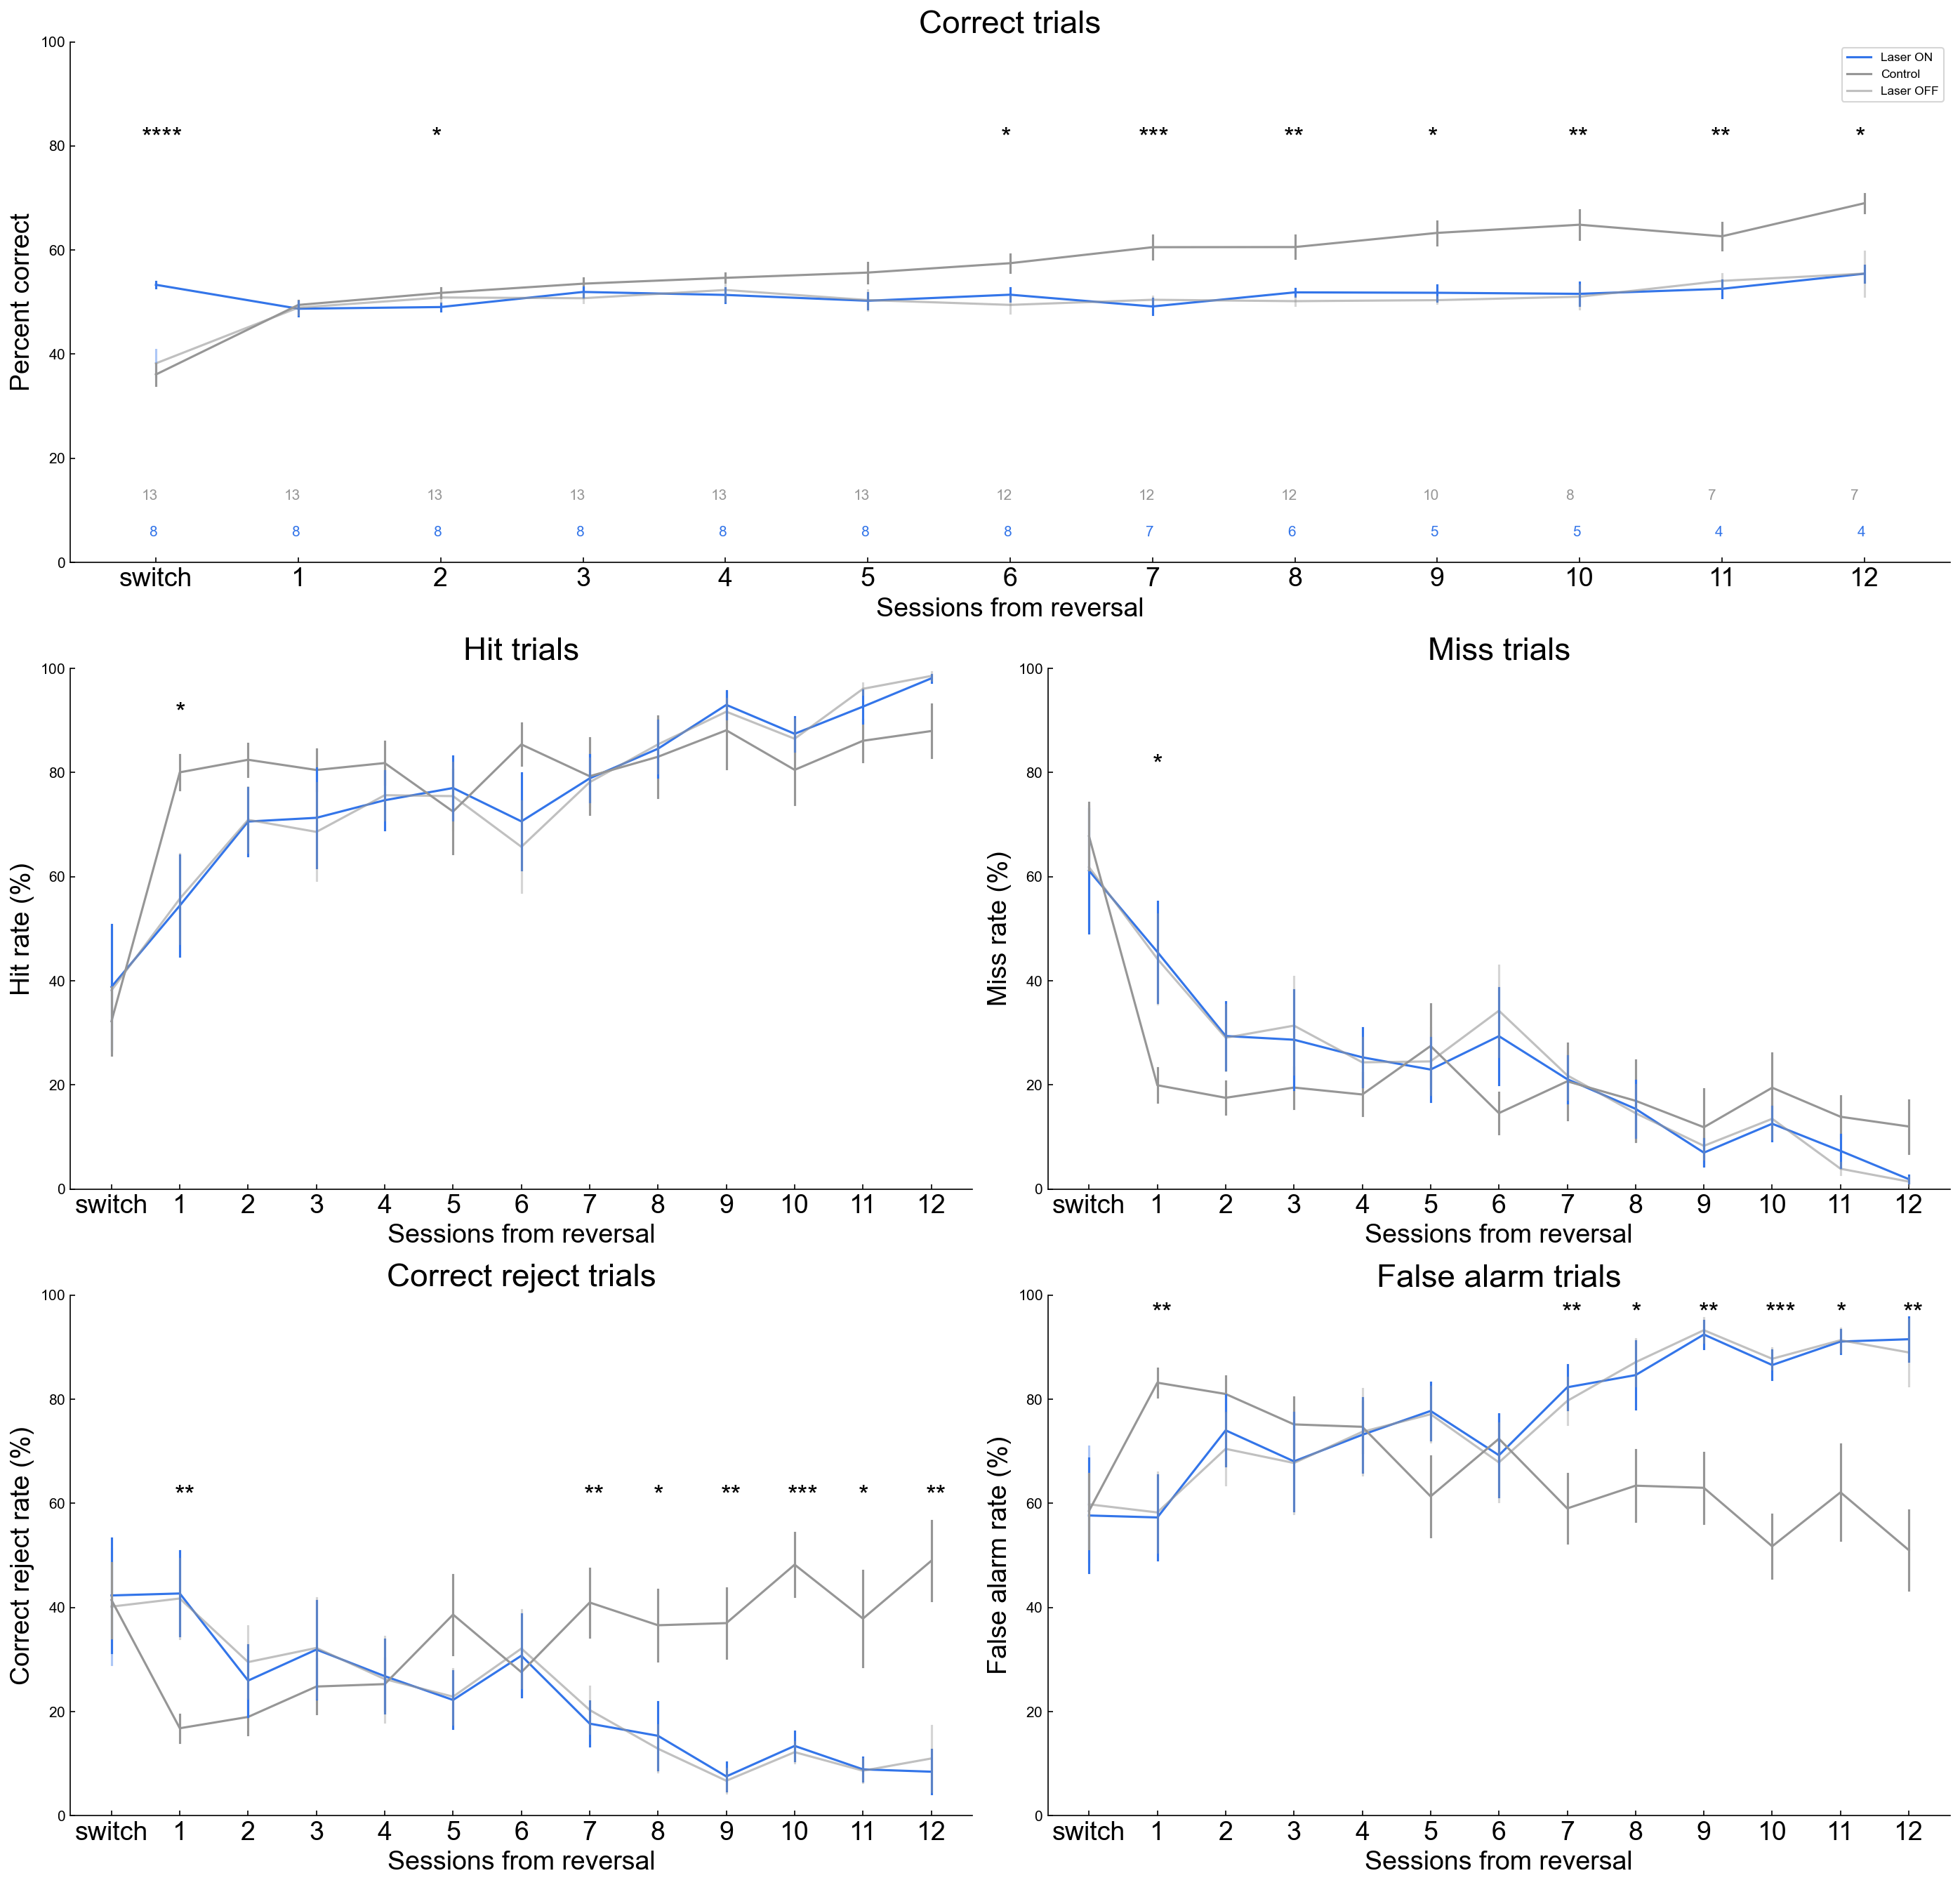

In [22]:
# PLOT BEHAVIOR

fig,ax = plt.subplots(6,1)
fig.set_figheight(18)
fig.set_figwidth(28)

ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
ax[3] = plt.subplot2grid((3, 3), (2, 0))
ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)
fig.tight_layout(pad=5)

fs = 18
title_fs = 22

#####################################################################
# CORRECT
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_corr_noNan[i][:],opsin_pct_corr_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][0],opsin_day0_postR_ON[:][0])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 80
if 0.01 < pval_day0_postR < 0.05:
    ax[0].text(0,sigYs_day0_postR, str('*'), size = fs)
if 0.005 < pval_day0_postR < 0.01:
    ax[0].text(0,sigYs_day0_postR, str('**'), size = fs)
if 0.001 < pval_day0_postR < 0.005:
    ax[0].text(0,sigYs_day0_postR, str('***'), size = fs)
if pval_day0_postR < 0.001:
    ax[0].text(-0.1,sigYs_day0_postR, str('****'), size = fs) 

# changing labels, accounting for 'days' before reversal
ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[0].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[0].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[0], corrData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[0].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[0], corrData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[0].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[0], corrData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[0].plot([days,days], [corrSEM_plot[0], corrSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[0].plot([days,days], [corrSEM_plot[2], corrSEM_plot[3]], color = LASER_COLOR) # control
ax[0].plot([days,days], [corrSEM_plot[4], corrSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

ax[0].plot([0,0], [opsin_day0_postR_ON_SEMhi[0], opsin_day0_postR_ON_SEMlo[0]], color = LASER_COLOR ) # opsin ON
ax[0].plot([0,0], [opsin_day0_postR_OFF_SEMhi[0], opsin_day0_postR_OFF_SEMlo[0]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[0].plot([0,0], [dual_day0_postR_OFF_SEMhi[0], dual_day0_postR_OFF_SEMlo[0]], color = GOOD_GREY) # control


# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[0].text(i+0.935,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[0].text(i+0.92,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[0].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[0].text(i+0.86,sigYs, str('****'), size = fs)

ax[0].set_xlabel('Sessions from reversal', size = fs)
ax[0].set_ylabel('Percent correct', size = fs)
ax[0].set_title('Correct trials', size = title_fs)
ax[0].legend()
ax[0].set_ylim(0,100)

# plotting # of days
ax[0].text(0-.05,5, num_nan_opsin[0], color = LASER_COLOR)
ax[0].text(0-.1,12, num_nan_dual[0], color = GOOD_GREY)
for i in range(12):
    ax[0].text(days[i]-.05,5, num_nan_opsin[i], color = LASER_COLOR)
    ax[0].text(days[i]-.1,12, num_nan_dual[i], color = GOOD_GREY)

#####################################################################
# HIT
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_hit_noNan[i][:],opsin_pct_hit_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][1],opsin_day0_postR_ON[:][1])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 90
if 0.01 < pval_day0_postR < 0.05:
    ax[1].text(0,sigYs_day0_postR, str('*'), size = fs)
if 0.005 < pval_day0_postR < 0.01:
    ax[1].text(0,sigYs_day0_postR, str('**'), size = fs)
if 0.001 < pval_day0_postR < 0.005:
    ax[1].text(0,sigYs_day0_postR, str('***'), size = fs)
if pval_day0_postR < 0.001:
    ax[1].text(0,sigYs_day0_postR, str('****'), size = fs)    
    
# changing labels, accounting for 'days' before reversal
ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[1].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[1].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[1], hitData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[1].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[1], hitData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[1].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[1], hitData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[1].plot([days,days], [hitSEM_plot[0], hitSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[1].plot([days,days], [hitSEM_plot[2], hitSEM_plot[3]], color = LASER_COLOR) # control
ax[1].plot([days,days], [hitSEM_plot[4], hitSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[1].plot([0,0], [opsin_day0_postR_ON_SEMhi[1], opsin_day0_postR_ON_SEMlo[1]], color = LASER_COLOR ) # opsin ON
ax[1].plot([0,0], [opsin_day0_postR_OFF_SEMhi[1], opsin_day0_postR_OFF_SEMlo[1]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[1].plot([0,0], [dual_day0_postR_OFF_SEMhi[1], dual_day0_postR_OFF_SEMlo[1]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 90
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[1].text(i+0.935,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[1].text(i+0.92,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[1].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[1].text(i+0.86,sigYs, str('****'), size = fs)

ax[1].set_xlabel('Sessions from reversal', size = fs)
ax[1].set_ylabel('Hit rate (%)', size = fs)
ax[1].set_title('Hit trials', size = title_fs)
ax[1].set_ylim(0,100)

#####################################################################
# MISS
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_miss_noNan[i][:],opsin_pct_miss_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
   
# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][2],opsin_day0_postR_ON[:][2])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 80
if 0.01 < pval_day0_postR < 0.05:
    ax[2].text(0,sigYs_day0_postR, str('*'), size = fs)
if 0.005 < pval_day0_postR < 0.01:
    ax[2].text(0,sigYs_day0_postR, str('**'), size = fs)
if 0.001 < pval_day0_postR < 0.005:
    ax[2].text(0,sigYs_day0_postR, str('***'), size = fs)
if pval_day0_postR < 0.001:
    ax[2].text(0,sigYs_day0_postR, str('****'), size = fs)      

# changing labels, accounting for 'days' before reversal
ax[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[2].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[2].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[2], missData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[2].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[2], missData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[2].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[2], missData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[2].plot([days,days], [missSEM_plot[0], missSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[2].plot([days,days], [missSEM_plot[2], missSEM_plot[3]], color = LASER_COLOR) # control
ax[2].plot([days,days], [missSEM_plot[4], missSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[2].plot([0,0], [opsin_day0_postR_ON_SEMhi[2], opsin_day0_postR_ON_SEMlo[2]], color = LASER_COLOR ) # opsin ON
ax[2].plot([0,0], [opsin_day0_postR_OFF_SEMhi[2], opsin_day0_postR_OFF_SEMlo[2]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[2].plot([0,0], [dual_day0_postR_OFF_SEMhi[2], dual_day0_postR_OFF_SEMlo[2]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[2].text(i+0.935,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[2].text(i+0.92,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[2].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[2].text(i+0.86,sigYs, str('****'), size = fs)

ax[2].set_xlabel('Sessions from reversal', size = fs)
ax[2].set_ylabel('Miss rate (%)', size = fs)
ax[2].set_title('Miss trials', size = title_fs)
ax[2].set_ylim(0,100)

#####################################################################
# CORRECT REJECT
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_creject_noNan[i][:],opsin_pct_creject_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][3],opsin_day0_postR_ON[:][3])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 60
if 0.01 < pval_day0_postR < 0.05:
    ax[3].text(0,sigYs_day0_postR, str('*'))
if 0.005 < pval_day0_postR < 0.01:
    ax[3].text(0,sigYs_day0_postR, str('**'))
if 0.001 < pval_day0_postR < 0.005:
    ax[3].text(0,sigYs_day0_postR, str('***'))
if pval_day0_postR < 0.001:
    ax[3].text(0,sigYs_day0_postR, str('****'))
  
# changing labels, accounting for 'days' before reversal
ax[3].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[3].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)
#ax[3].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[3].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[3], crejectData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[3].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[3], crejectData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[3].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[3], crejectData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[3].plot([days,days], [crejectSEM_plot[0], crejectSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[3].plot([days,days], [crejectSEM_plot[2], crejectSEM_plot[3]], color = LASER_COLOR) # control
ax[3].plot([days,days], [crejectSEM_plot[4], crejectSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[3].plot([0,0], [opsin_day0_postR_ON_SEMhi[3], opsin_day0_postR_ON_SEMlo[3]], color = LASER_COLOR ) # opsin ON
ax[3].plot([0,0], [opsin_day0_postR_OFF_SEMhi[3], opsin_day0_postR_OFF_SEMlo[3]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[3].plot([0,0], [dual_day0_postR_OFF_SEMhi[3], dual_day0_postR_OFF_SEMlo[3]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 60
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[3].text(i+0.935,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[3].text(i+0.92,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[3].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[3].text(i+0.86,sigYs, str('****'), size = fs)

ax[3].set_xlabel('Sessions from reversal', size = fs)
ax[3].set_ylabel('Correct reject rate (%)', size = fs)
ax[3].set_title('Correct reject trials', size = title_fs)
ax[3].set_ylim(0,100)

#####################################################################
# FALSE ALARM
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_falarm_noNan[i][:],opsin_pct_falarm_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05 

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][4],opsin_day0_postR_ON[:][4])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 95
if 0.01 < pval_day0_postR < 0.05:
    ax[4].text(0,sigYs_day0_postR, str('*'), size = fs)
if 0.005 < pval_day0_postR < 0.01:
    ax[4].text(0,sigYs_day0_postR, str('**'), size = fs)
if 0.001 < pval_day0_postR < 0.005:
    ax[4].text(0,sigYs_day0_postR, str('***'), size = fs)
if pval_day0_postR < 0.001:
    ax[4].text(0,sigYs, str('****'), size = fs)

# changing labels, accounting for 'days' before reversal
ax[4].set_xticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[4].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[4].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[4], falarmData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[4].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[4], falarmData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[4].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[4], falarmData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[4].plot([days,days], [falarmSEM_plot[0], falarmSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[4].plot([days,days], [falarmSEM_plot[2], falarmSEM_plot[3]], color = LASER_COLOR) # control
ax[4].plot([days,days], [falarmSEM_plot[4], falarmSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[4].plot([0,0], [opsin_day0_postR_ON_SEMhi[4], opsin_day0_postR_ON_SEMlo[4]], color = LASER_COLOR ) # opsin ON
ax[4].plot([0,0], [opsin_day0_postR_OFF_SEMhi[4], opsin_day0_postR_OFF_SEMlo[4]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[4].plot([0,0], [dual_day0_postR_OFF_SEMhi[4], dual_day0_postR_OFF_SEMlo[4]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 95
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[4].text(i+0.935,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[4].text(i+0.92,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[4].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[4].text(i+0.86,sigYs, str('****'), size = fs)

ax[4].set_xlabel('Sessions from reversal', size = fs)
ax[4].set_ylabel('False alarm rate (%)', size = fs)
ax[4].set_title('False alarm trials', size = title_fs)
ax[4].set_ylim(0,100)
#####################################################################

plt.tight_layout()
plt.savefig('Opsin Effects Across Sessions, all of post reversal.pdf')
plt.show()

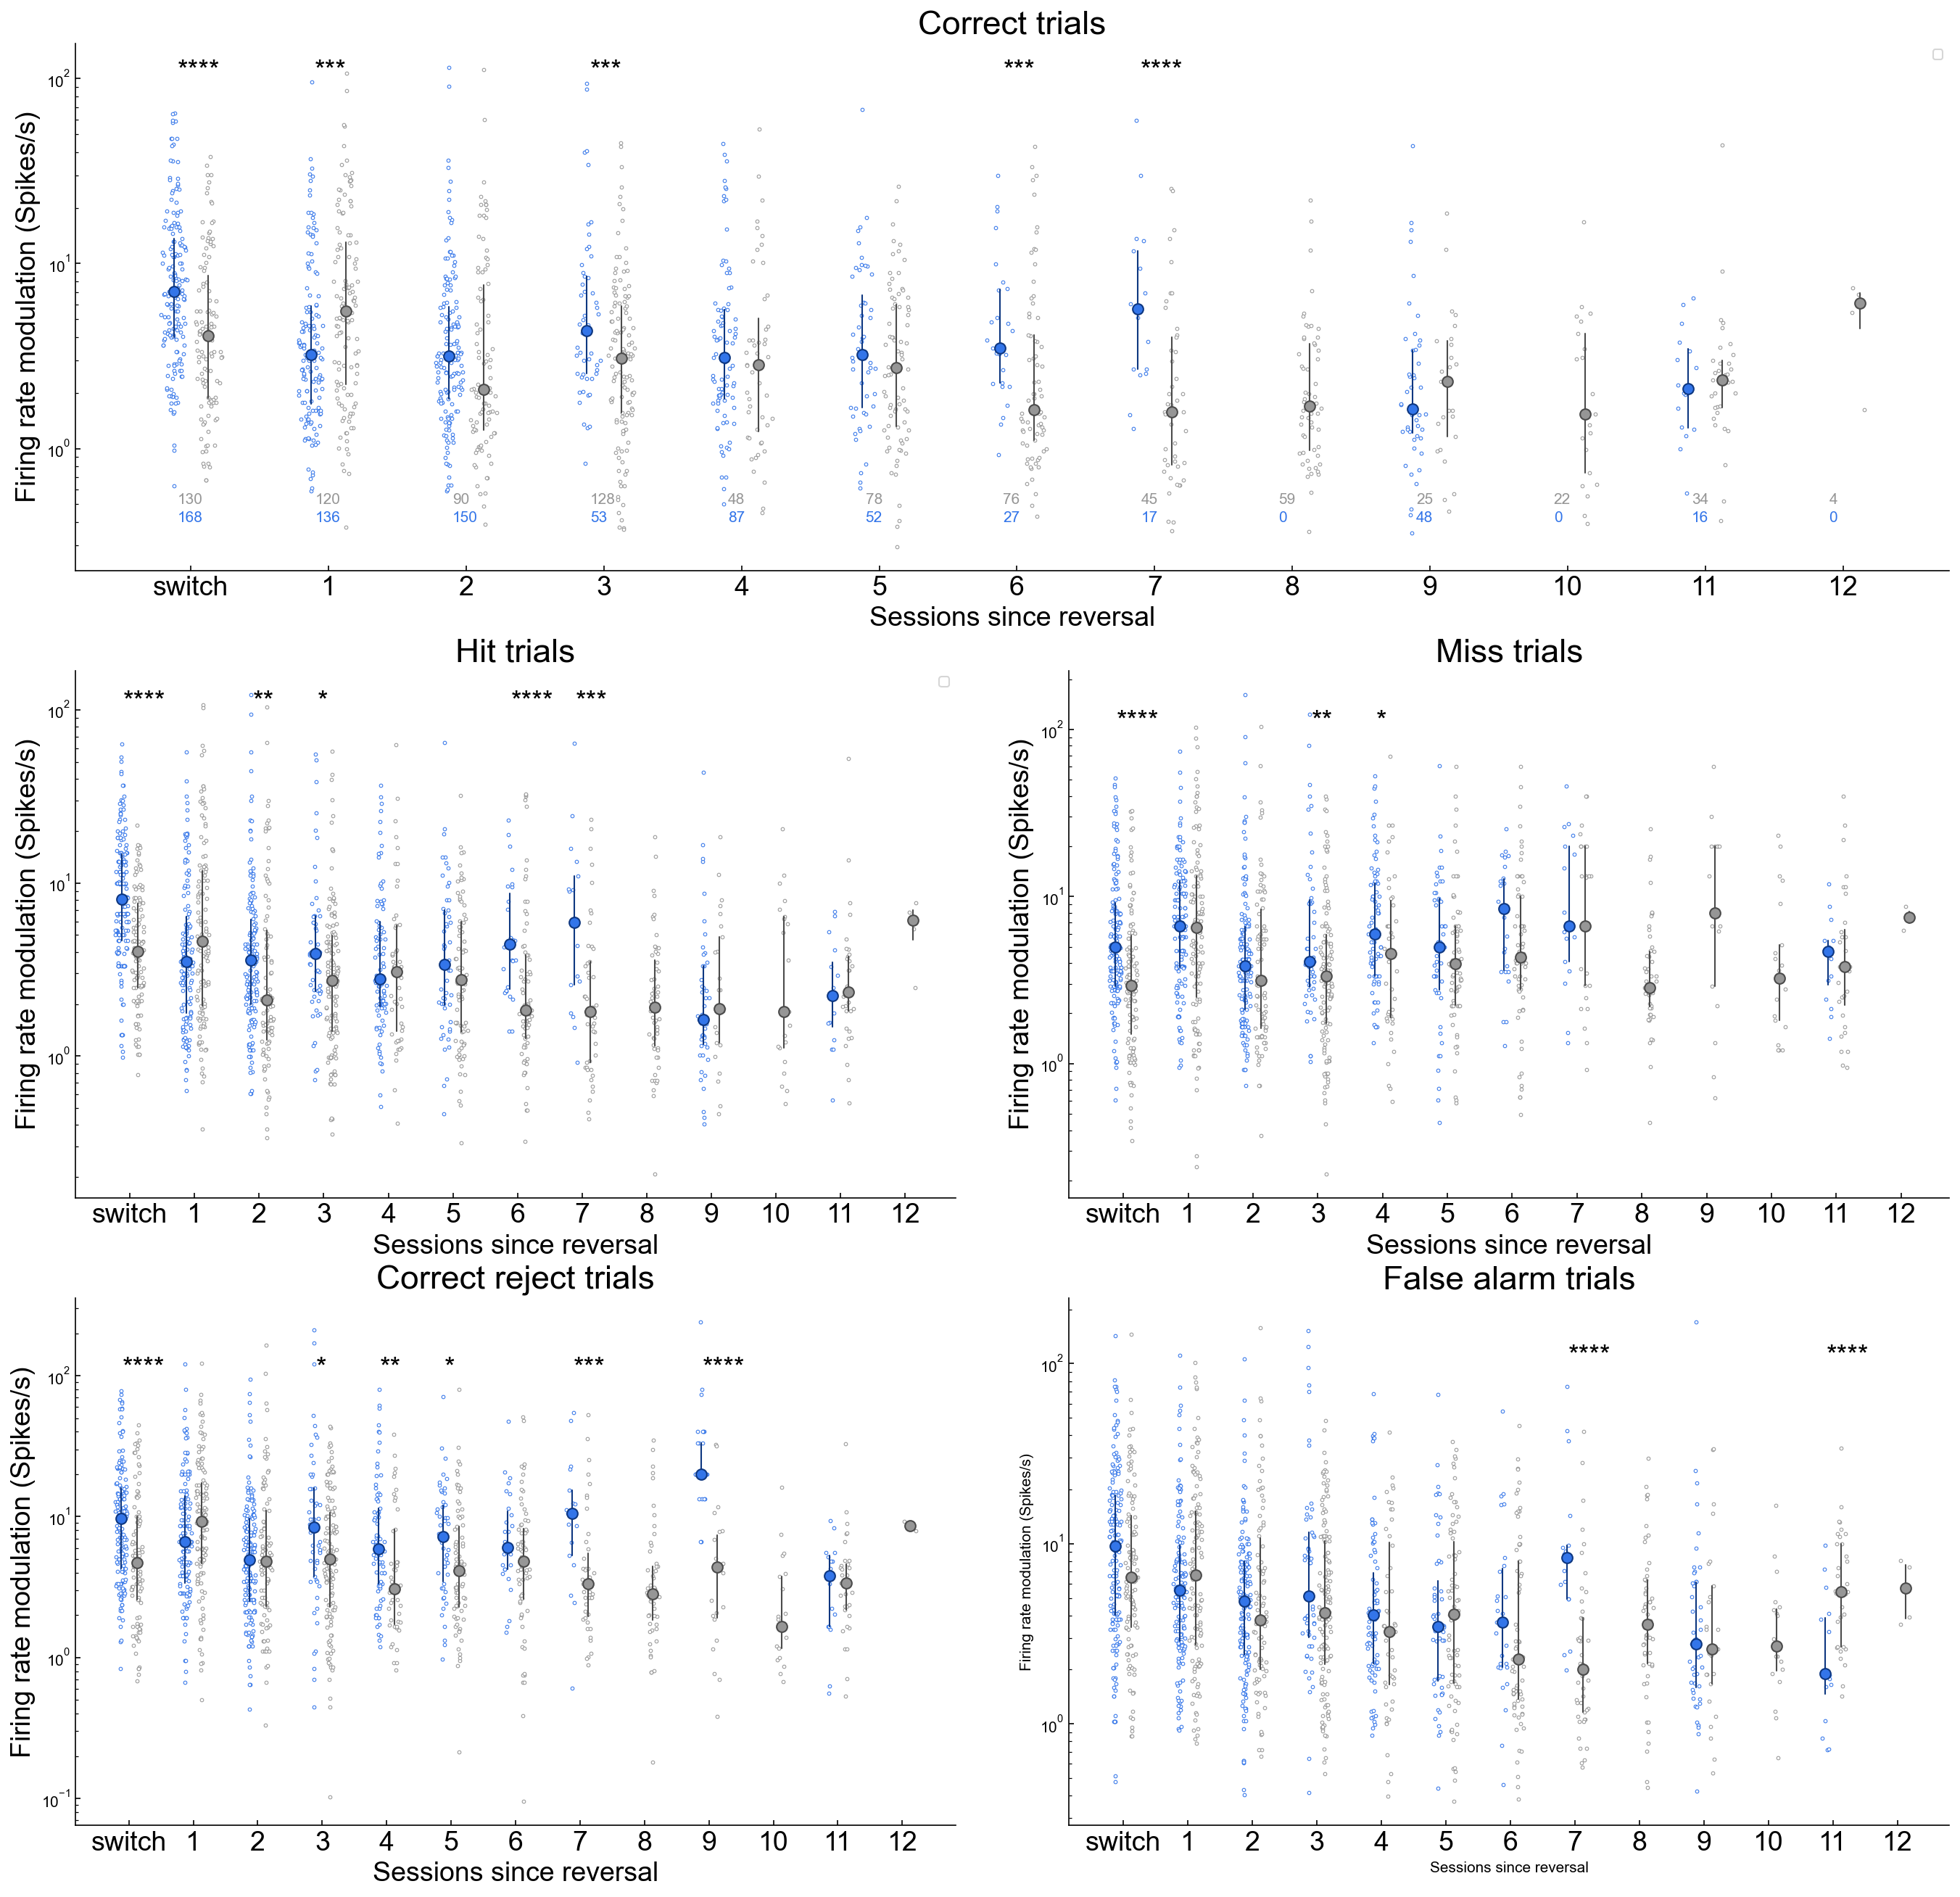

In [24]:
# PLOT FR MODULATION

import numpy as np
import matplotlib.pyplot as plt

# fs = 18  # fontsize
# fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(16, 12))
# fig.tight_layout(pad=5)

fig,ax = plt.subplots(6,1)
fig.set_figheight(18)
fig.set_figwidth(28)

ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), colspan=1)
ax[3] = plt.subplot2grid((3, 3), (2, 0), colspan=1)
ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)
fig.tight_layout(pad=5)

fs = 18
title_fs = 22

days = np.arange(0,13) + 1
################################################################################################
## CORRECT
################################################################################################
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_corr
    dual_test = dual_day_clust_off_corr
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_corr)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_corr)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_corr)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_corr)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[0].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[0].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_corr)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_corr[i])       
for idx,column in enumerate(opsin_day_clust_on_corr):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[0].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[0].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_corr)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_corr[i])       
for idx,column in enumerate(dual_day_clust_off_corr):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[0].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    ax[0].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
##############################################################
# cleaning up axes
ax[0].set_yscale('log')
ax[0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[0].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)
ax[0].set_ylabel('Firing rate modulation (Spikes/s)', size = fs)
ax[0].set_xlabel('Sessions since reversal', size = fs)
ax[0].set_title('Correct trials', fontsize=title_fs)
ax[0].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[0].text(i+0.9,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[0].text(i+0.9,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[0].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[0].text(i+0.9,sigYs, str('****'), size = fs)

# plotting # of clusters
for i in range(13):
    ax[0].text(days[i]-.1,0.4, int(opsin_numClusters_across_days[i]), color = LASER_COLOR)
    ax[0].text(days[i]-.1,0.5, int(dual_numClusters_across_days[i]), color = GOOD_GREY)
    
################################################################################################
## HIT
################################################################################################
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_hit
    dual_test = dual_day_clust_off_hit
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_hit)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_hit)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_hit)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_hit)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[1].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[1].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_hit)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_hit[i])       
for idx,column in enumerate(opsin_day_clust_on_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[1].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[1].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_hit)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_hit[i])       
for idx,column in enumerate(dual_day_clust_off_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[1].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    ax[1].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
##############################################################
# cleaning up axes
ax[1].set_yscale('log')
ax[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[1].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)
ax[1].set_ylabel('Firing rate modulation (Spikes/s)', size = fs)
ax[1].set_xlabel('Sessions since reversal', size = fs)
ax[1].set_title('Hit trials', fontsize=title_fs)
ax[1].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[1].text(i+0.9,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[1].text(i+0.9,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[1].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[1].text(i+0.9,sigYs, str('****'), size = fs)
        
################################################################################################
## MISS
################################################################################################
# compute significance
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_miss
    dual_test = dual_day_clust_off_miss
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_miss)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_miss)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_miss)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_miss)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[2].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[2].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_miss)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_miss[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[2].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    ax[2].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_miss)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_miss[i])       
for idx,column in enumerate(dual_day_clust_off_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[2].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[2].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
ax[2].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[2].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)
ax[2].set_ylabel('Firing rate modulation (Spikes/s)', size = fs)
ax[2].set_xlabel('Sessions since reversal', size = fs)
ax[2].set_title('Miss trials', fontsize=title_fs)
ax[2].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[2].text(i+0.9,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[2].text(i+0.9,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[2].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[2].text(i+0.9,sigYs, str('****'), size = fs)


################################################################################################
## CORRECT REJECT
################################################################################################
# # compute significance
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_creject
    dual_test = dual_day_clust_off_creject
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_creject)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_creject)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_creject)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_creject)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[3].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[3].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_creject)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_creject[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[3].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    ax[3].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_creject)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_creject[i])       
for idx,column in enumerate(dual_day_clust_off_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[3].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[3].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
ax[3].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[3].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)
ax[3].set_ylabel('Firing rate modulation (Spikes/s)', size = fs)
ax[3].set_xlabel('Sessions since reversal', size = fs)
ax[3].set_title('Correct reject trials', fontsize=title_fs)
ax[3].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[3].text(i+0.9,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[3].text(i+0.9,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[3].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[3].text(i+0.9,sigYs, str('****'), size = fs)

################################################################################################
## FALSE ALARM
################################################################################################
# compute significance
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_falarm
    dual_test = dual_day_clust_off_falarm
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_falarm)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_falarm)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_falarm)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_falarm)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[4].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[4].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_falarm)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_falarm[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[4].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    ax[4].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_falarm)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_falarm[i])       
for idx,column in enumerate(dual_day_clust_off_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[4].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[4].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
ax[4].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[4].set_xticklabels(['switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = fs)
ax[4].set_ylabel('Firing rate modulation (Spikes/s)')
ax[4].set_xlabel('Sessions since reversal')
ax[4].set_title('False alarm trials', fontsize=title_fs)
ax[4].set_yscale('log')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[4].text(i+0.9,sigYs, str('*'), size = fs)
    if 0.005 < pval[i] < 0.01:
        ax[4].text(i+0.9,sigYs, str('**'), size = fs)
    if 0.001 < pval[i] < 0.005:
        ax[4].text(i+0.9,sigYs, str('***'), size = fs)
    if pval[i] < 0.001:
        ax[4].text(i+0.9,sigYs, str('****'), size = fs)

plt.savefig('Opsin Effects on FR Across Sessions, laser ON v Control.pdf')

# Now going to combine above two graphs

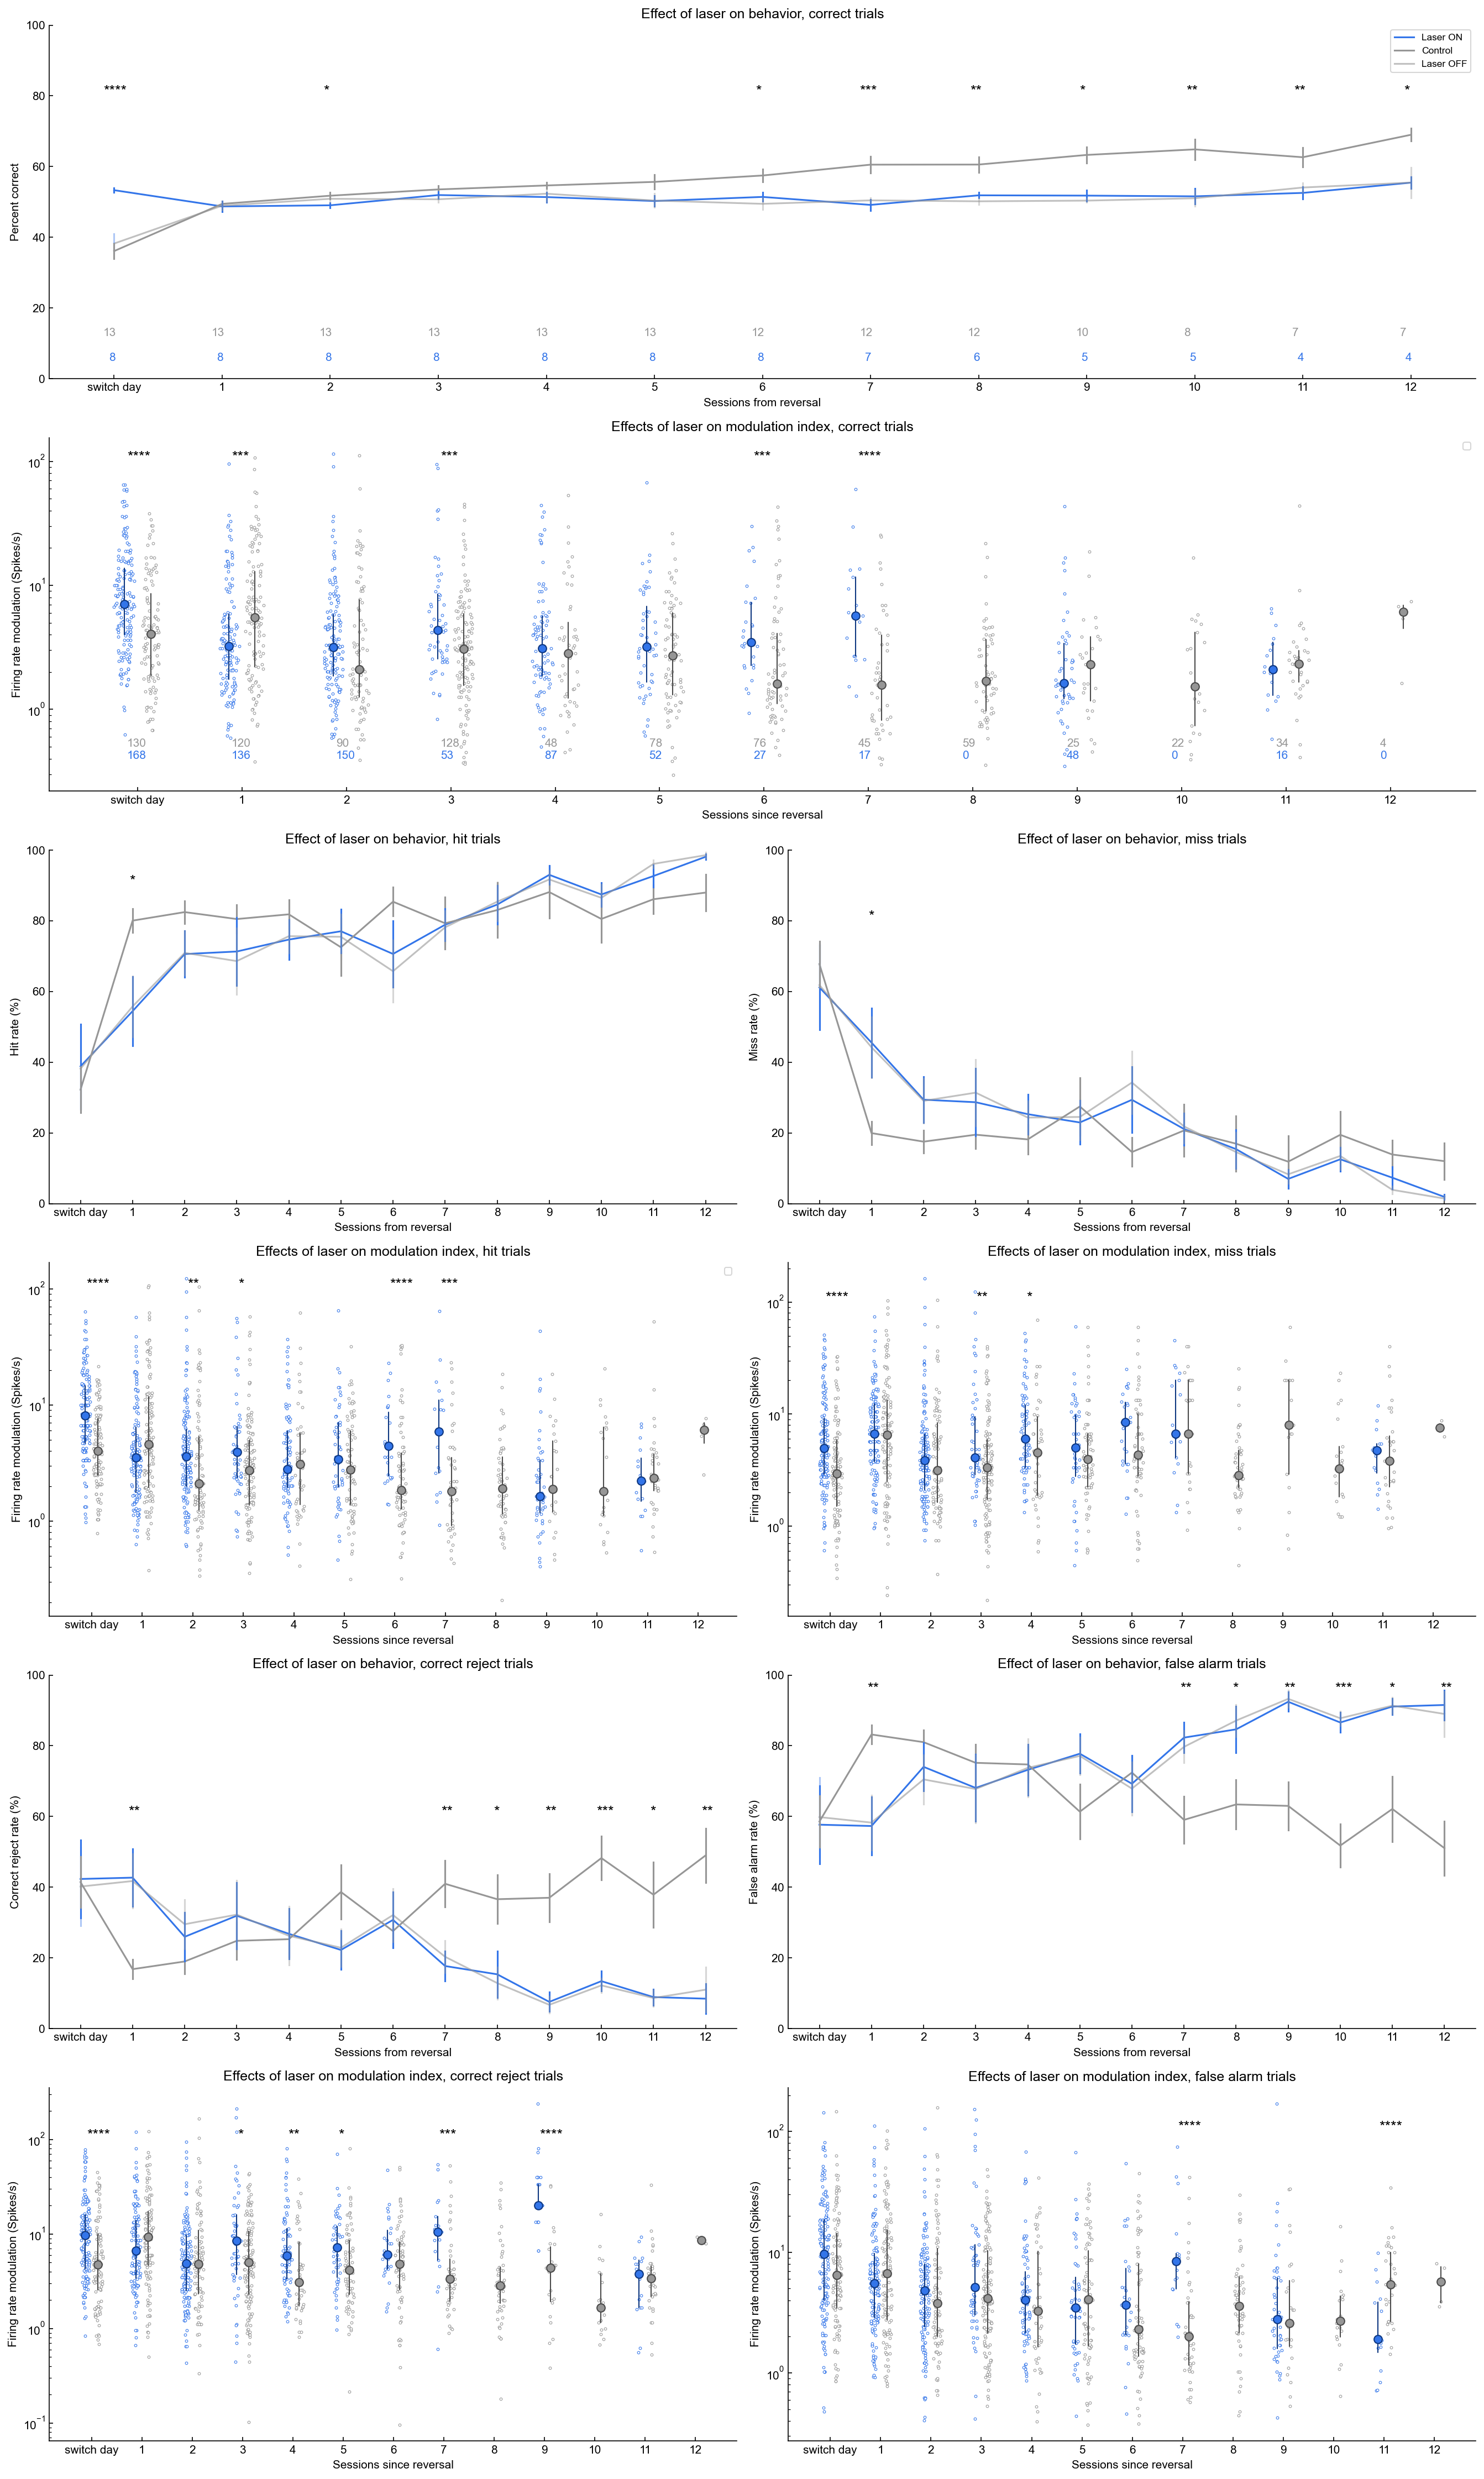

In [78]:
import numpy as np
import matplotlib.pyplot as plt

fs = 18  # fontsize

fig,ax = plt.subplots(10,1)
fig.set_figheight(30)
fig.set_figwidth(18)

ax[0] = plt.subplot2grid(shape=(6, 2), loc=(0, 0), colspan=2)
ax[1] = plt.subplot2grid(shape=(6, 2), loc=(1, 0), colspan=2)
ax[2] = plt.subplot2grid(shape=(6, 2), loc=(2, 0), colspan=1)
ax[3] = plt.subplot2grid(shape=(6, 2), loc=(2, 1), colspan=1)
ax[4] = plt.subplot2grid(shape=(6, 2), loc=(3, 0), colspan=1)
ax[5] = plt.subplot2grid(shape=(6, 2), loc=(3, 1), colspan=1)
ax[6] = plt.subplot2grid(shape=(6, 2), loc=(4, 0), colspan=1)
ax[7] = plt.subplot2grid(shape=(6, 2), loc=(4, 1), colspan=1)
ax[8] = plt.subplot2grid(shape=(6, 2), loc=(5, 0), colspan=1)
ax[9] = plt.subplot2grid(shape=(6, 2), loc=(5, 1), colspan=1)

fig.tight_layout(pad=5)

#################################################################################################################################
### CORRECT TRIALS
#################################################################################################################################

#####################################################################
# CORRECT BEHAVIOR
#####################################################################
days = np.arange(1,13)

sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_corr_noNan[i][:],opsin_pct_corr_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][0],opsin_day0_postR_ON[:][0])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 80
if 0.01 < pval_day0_postR < 0.05:
    ax[0].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[0].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[0].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[0].text(-0.1,sigYs_day0_postR, str('****'), size = 13) 

# changing labels, accounting for 'days' before reversal
ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[0].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[0].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[0], corrData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[0].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[0], corrData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[0].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[0], corrData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[0].plot([days,days], [corrSEM_plot[0], corrSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[0].plot([days,days], [corrSEM_plot[2], corrSEM_plot[3]], color = LASER_COLOR) # control
ax[0].plot([days,days], [corrSEM_plot[4], corrSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

ax[0].plot([0,0], [opsin_day0_postR_ON_SEMhi[0], opsin_day0_postR_ON_SEMlo[0]], color = LASER_COLOR ) # opsin ON
ax[0].plot([0,0], [opsin_day0_postR_OFF_SEMhi[0], opsin_day0_postR_OFF_SEMlo[0]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[0].plot([0,0], [dual_day0_postR_OFF_SEMhi[0], dual_day0_postR_OFF_SEMlo[0]], color = GOOD_GREY) # control


# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[0].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[0].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[0].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[0].text(i+0.86,sigYs, str('****'), size = 13)

ax[0].set_xlabel('Sessions from reversal')
ax[0].set_ylabel('Percent correct')
ax[0].set_title('Effect of laser on behavior, correct trials')
ax[0].legend()
ax[0].set_ylim(0,100)

# plotting # of days
ax[0].text(0-.05,5, num_nan_opsin[0], color = LASER_COLOR)
ax[0].text(0-.1,12, num_nan_dual[0], color = GOOD_GREY)
for i in range(12):
    ax[0].text(days[i]-.05,5, num_nan_opsin[i], color = LASER_COLOR)
    ax[0].text(days[i]-.1,12, num_nan_dual[i], color = GOOD_GREY)


#####################################################################
# CORRECT FR MODULATION
#####################################################################
days = np.arange(0,13) + 1

sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_corr
    dual_test = dual_day_clust_off_corr
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_corr)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_corr)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_corr)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_corr)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[1].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[1].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_corr)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_corr[i])       
for idx,column in enumerate(opsin_day_clust_on_corr):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[1].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[1].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_corr)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_corr[i])       
for idx,column in enumerate(dual_day_clust_off_corr):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[1].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    ax[1].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
##############################################################
# cleaning up axes
ax[1].set_yscale('log')
ax[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[1].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
ax[1].set_ylabel('Firing rate modulation (Spikes/s)')
ax[1].set_xlabel('Sessions since reversal')
ax[1].set_title('Effects of laser on modulation index, correct trials')
ax[1].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[1].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[1].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[1].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[1].text(i+0.9,sigYs, str('****'), size = 13)

# plotting # of clusters
for i in range(13):
    ax[1].text(days[i]-.1,0.4, int(opsin_numClusters_across_days[i]), color = LASER_COLOR)
    ax[1].text(days[i]-.1,0.5, int(dual_numClusters_across_days[i]), color = GOOD_GREY)


#################################################################################################################################
### HIT TRIALS
#################################################################################################################################

#####################################################################
# HIT BEHAVIOR
#####################################################################
days = np.arange(1,13)

sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_hit_noNan[i][:],opsin_pct_hit_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][1],opsin_day0_postR_ON[:][1])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 90
if 0.01 < pval_day0_postR < 0.05:
    ax[2].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[2].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[2].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[2].text(0,sigYs_day0_postR, str('****'), size = 13)    
    
# changing labels, accounting for 'days' before reversal
ax[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[2].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[2].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[1], hitData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[2].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[1], hitData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[2].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[1], hitData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[2].plot([days,days], [hitSEM_plot[0], hitSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[2].plot([days,days], [hitSEM_plot[2], hitSEM_plot[3]], color = LASER_COLOR) # control
ax[2].plot([days,days], [hitSEM_plot[4], hitSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[2].plot([0,0], [opsin_day0_postR_ON_SEMhi[1], opsin_day0_postR_ON_SEMlo[1]], color = LASER_COLOR ) # opsin ON
ax[2].plot([0,0], [opsin_day0_postR_OFF_SEMhi[1], opsin_day0_postR_OFF_SEMlo[1]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[2].plot([0,0], [dual_day0_postR_OFF_SEMhi[1], dual_day0_postR_OFF_SEMlo[1]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 90
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[2].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[2].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[2].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[2].text(i+0.86,sigYs, str('****'), size = 13)

ax[2].set_xlabel('Sessions from reversal')
ax[2].set_ylabel('Hit rate (%)')
ax[2].set_title('Effect of laser on behavior, hit trials')
ax[2].set_ylim(0,100)


#####################################################################
# HIT FR MODULATION
#####################################################################
days = np.arange(0,13)

sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_hit
    dual_test = dual_day_clust_off_hit
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_hit)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_hit)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_hit)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_hit)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[4].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[4].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_hit)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_hit[i])       
for idx,column in enumerate(opsin_day_clust_on_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[4].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[4].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_hit)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_hit[i])       
for idx,column in enumerate(dual_day_clust_off_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[4].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    ax[4].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
##############################################################
# cleaning up axes
ax[4].set_yscale('log')
ax[4].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[4].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
ax[4].set_ylabel('Firing rate modulation (Spikes/s)')
ax[4].set_xlabel('Sessions since reversal')
ax[4].set_title('Effects of laser on modulation index, hit trials')
ax[4].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[4].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[4].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[4].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[4].text(i+0.9,sigYs, str('****'), size = 13)

#################################################################################################################################
### MISS TRIALS
#################################################################################################################################

#####################################################################
# MISS BEHAVIOR
#####################################################################
days = np.arange(1,13)

sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_miss_noNan[i][:],opsin_pct_miss_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
   
# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][2],opsin_day0_postR_ON[:][2])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 80
if 0.01 < pval_day0_postR < 0.05:
    ax[3].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[3].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[3].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[3].text(0,sigYs_day0_postR, str('****'), size = 13)      

# changing labels, accounting for 'days' before reversal
ax[3].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[3].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[3].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[2], missData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[3].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[2], missData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[3].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[2], missData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[3].plot([days,days], [missSEM_plot[0], missSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[3].plot([days,days], [missSEM_plot[2], missSEM_plot[3]], color = LASER_COLOR) # control
ax[3].plot([days,days], [missSEM_plot[4], missSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[3].plot([0,0], [opsin_day0_postR_ON_SEMhi[2], opsin_day0_postR_ON_SEMlo[2]], color = LASER_COLOR ) # opsin ON
ax[3].plot([0,0], [opsin_day0_postR_OFF_SEMhi[2], opsin_day0_postR_OFF_SEMlo[2]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[3].plot([0,0], [dual_day0_postR_OFF_SEMhi[2], dual_day0_postR_OFF_SEMlo[2]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[3].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[3].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[3].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[3].text(i+0.86,sigYs, str('****'), size = 13)

ax[3].set_xlabel('Sessions from reversal')
ax[3].set_ylabel('Miss rate (%)')
ax[3].set_title('Effect of laser on behavior, miss trials')
ax[3].set_ylim(0,100)


#####################################################################
# MISS FR MODULATION
#####################################################################
days = np.arange(0,13)

# compute significance
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_miss
    dual_test = dual_day_clust_off_miss
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_miss)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_miss)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_miss)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_miss)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[5].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[5].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_miss)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_miss[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[5].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    ax[5].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_miss)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_miss[i])       
for idx,column in enumerate(dual_day_clust_off_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[5].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[5].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
ax[5].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[5].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
ax[5].set_ylabel('Firing rate modulation (Spikes/s)')
ax[5].set_xlabel('Sessions since reversal')
ax[5].set_title('Effects of laser on modulation index, miss trials')
ax[5].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[5].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[5].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[5].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[5].text(i+0.9,sigYs, str('****'), size = 13)



#################################################################################################################################
### CORRECT REJECT TRIALS
#################################################################################################################################

#####################################################################
# CORRECT REJECT BEHAVIOR
#####################################################################
days = np.arange(1,13)

sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_creject_noNan[i][:],opsin_pct_creject_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][3],opsin_day0_postR_ON[:][3])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 60
if 0.01 < pval_day0_postR < 0.05:
    ax[6].text(0,sigYs_day0_postR, str('*'))
if 0.005 < pval_day0_postR < 0.01:
    ax[6].text(0,sigYs_day0_postR, str('**'))
if 0.001 < pval_day0_postR < 0.005:
    ax[6].text(0,sigYs_day0_postR, str('***'))
if pval_day0_postR < 0.001:
    ax[6].text(0,sigYs_day0_postR, str('****'))
  
# changing labels, accounting for 'days' before reversal
ax[6].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[6].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
#ax[3].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[6].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[3], crejectData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[6].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[3], crejectData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[6].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[3], crejectData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[6].plot([days,days], [crejectSEM_plot[0], crejectSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[6].plot([days,days], [crejectSEM_plot[2], crejectSEM_plot[3]], color = LASER_COLOR) # control
ax[6].plot([days,days], [crejectSEM_plot[4], crejectSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[6].plot([0,0], [opsin_day0_postR_ON_SEMhi[3], opsin_day0_postR_ON_SEMlo[3]], color = LASER_COLOR ) # opsin ON
ax[6].plot([0,0], [opsin_day0_postR_OFF_SEMhi[3], opsin_day0_postR_OFF_SEMlo[3]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[6].plot([0,0], [dual_day0_postR_OFF_SEMhi[3], dual_day0_postR_OFF_SEMlo[3]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 60
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[6].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[6].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[6].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[6].text(i+0.86,sigYs, str('****'), size = 13)

ax[6].set_xlabel('Sessions from reversal')
ax[6].set_ylabel('Correct reject rate (%)')
ax[6].set_title('Effect of laser on behavior, correct reject trials')
ax[6].set_ylim(0,100)


#####################################################################
# CORRECT REJECT FR MODULATION
#####################################################################
days = np.arange(0,13)

sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_creject
    dual_test = dual_day_clust_off_creject
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_creject)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_creject)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_creject)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_creject)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[8].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[8].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_creject)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_creject[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[8].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    ax[8].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_creject)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_creject[i])       
for idx,column in enumerate(dual_day_clust_off_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[8].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[8].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
ax[8].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[8].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
ax[8].set_ylabel('Firing rate modulation (Spikes/s)')
ax[8].set_xlabel('Sessions since reversal')
ax[8].set_title('Effects of laser on modulation index, correct reject trials')
ax[8].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[8].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[8].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[8].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[8].text(i+0.9,sigYs, str('****'), size = 13)

#################################################################################################################################
### FALSE ALARM TRIALS
#################################################################################################################################

#####################################################################
# FALSE ALARM BEHAVIOR
#####################################################################
days = np.arange(1,13)

sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_falarm_noNan[i][:],opsin_pct_falarm_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05 

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][4],opsin_day0_postR_ON[:][4])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 95
if 0.01 < pval_day0_postR < 0.05:
    ax[7].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[7].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[7].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[7].text(0,sigYs, str('****'), size = 13)

# changing labels, accounting for 'days' before reversal
ax[7].set_xticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[7].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[7].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[4], falarmData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[7].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[4], falarmData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[7].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[4], falarmData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[7].plot([days,days], [falarmSEM_plot[0], falarmSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[7].plot([days,days], [falarmSEM_plot[2], falarmSEM_plot[3]], color = LASER_COLOR) # control
ax[7].plot([days,days], [falarmSEM_plot[4], falarmSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[7].plot([0,0], [opsin_day0_postR_ON_SEMhi[4], opsin_day0_postR_ON_SEMlo[4]], color = LASER_COLOR ) # opsin ON
ax[7].plot([0,0], [opsin_day0_postR_OFF_SEMhi[4], opsin_day0_postR_OFF_SEMlo[4]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[7].plot([0,0], [dual_day0_postR_OFF_SEMhi[4], dual_day0_postR_OFF_SEMlo[4]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 95
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[7].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[7].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[7].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[7].text(i+0.86,sigYs, str('****'), size = 13)

ax[7].set_xlabel('Sessions from reversal')
ax[7].set_ylabel('False alarm rate (%)')
ax[7].set_title('Effect of laser on behavior, false alarm trials')
ax[7].set_ylim(0,100)


#####################################################################
# FALSE ALARM FR MODULATION
#####################################################################
days = np.arange(0,13)

sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_falarm
    dual_test = dual_day_clust_off_falarm
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_falarm)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_falarm)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_falarm)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_falarm)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
ax[9].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
ax[9].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_falarm)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_falarm[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[9].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    ax[9].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_falarm)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_falarm[i])       
for idx,column in enumerate(dual_day_clust_off_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    ax[9].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax[9].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
ax[9].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax[9].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
ax[9].set_ylabel('Firing rate modulation (Spikes/s)')
ax[9].set_xlabel('Sessions since reversal')
ax[9].set_title('Effects of laser on modulation index, false alarm trials')
ax[9].set_yscale('log')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        ax[9].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[9].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[9].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[9].text(i+0.9,sigYs, str('****'), size = 13)

plt.tight_layout()
plt.savefig('Combined effects of laser on behavior and FR modulation.pdf')
plt.show()


In [95]:
laser_on = sessionfile.trials.laser_stimulation
correct = sessionfile.trials.correct
laser_on = np.array(np.where(laser_on)[0])
laser_on = laser_on[np.isin(laser_on,sessionfile.trim[10].trimmed_trials)]
correct = np.array(np.where(correct)[0])
correct = correct[np.isin(correct,sessionfile.trim[10].trimmed_trials)]

laseron_correct = np.intersect1d(laser_on, correct)
